-------------------

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [62]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


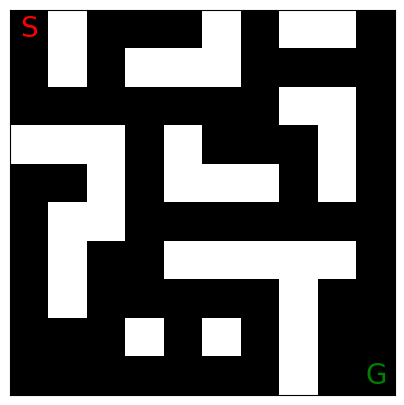

In [63]:
# Define the maze environment
class Maze:
    def __init__(self, maze, start_position, goal_position):
        self.maze = maze
        self.maze_height = maze.shape[0]
        self.maze_width = maze.shape[1]
        self.start_position = start_position
        self.goal_position = goal_position

    def show_maze(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.maze, cmap='gray')
        plt.text(self.start_position[0], self.start_position[1], 'S', 
                ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', 
                ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()

maze_layout = np.array([
    [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [1, 1, 1, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
])


# Initialize maze environment
start_pos = (0, 0)  # Starting position (top-left)
goal_pos = (9, 9)   # Goal position (bottom-right)
maze = Maze(maze_layout, start_pos, goal_pos)
maze.show_maze()
# Define possible actions: Up, Down, Left, Right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Define rewards
goal_reward = 200
wall_penalty = -5
step_penalty = -0.5

In [69]:

class ICModule(nn.Module):
    """Intrinsic Curiosity Module for better exploration"""
    def __init__(self, state_size, action_size, hidden_size=32):
        super(ICModule, self).__init__()
        
        # Feature encoder
        self.feature_encoder = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        ).to(device)
        
        # Forward model
        self.forward_model = nn.Sequential(
            nn.Linear(hidden_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        ).to(device)
        
        # Inverse model
        self.inverse_model = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        ).to(device)
        
    def forward(self, state, next_state, action):
        # Encode states
        state_feat = self.feature_encoder(state)
        next_state_feat = self.feature_encoder(next_state)
        
        # Forward model prediction
        action_onehot = F.one_hot(action.long(), 4).float()  # 4 actions
        forward_input = torch.cat([state_feat, action_onehot], dim=1)
        predicted_next_feat = self.forward_model(forward_input)
        
        # Inverse model prediction
        inverse_input = torch.cat([state_feat, next_state_feat], dim=1)
        predicted_action = self.inverse_model(inverse_input)
        
        # Calculate curiosity reward (forward model error)
        curiosity_reward = torch.norm(predicted_next_feat - next_state_feat, dim=1)
        
        return curiosity_reward, predicted_action

class ActorCritic(nn.Module):
    """Actor-Critic Network"""
    def __init__(self, state_size, action_size, hidden_size=64):
        super(ActorCritic, self).__init__()
        
        # Shared features
        self.features = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU()
        ).to(device)
        
        # Actor (policy) head
        self.actor = nn.Sequential(
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=1)
        ).to(device)
        
        # Critic (value) head
        self.critic = nn.Linear(hidden_size, 1).to(device)
        
    def forward(self, state):
        features = self.features(state)
        action_probs = self.actor(features)
        state_value = self.critic(features)
        return action_probs, state_value

class CuriousActorCriticAgent:
    def __init__(self, maze, learning_rate=0.0001, gamma=0.99, curiosity_weight=0.1):
        state_size = 2  # x, y coordinates
        action_size = 4  # up, down, left, right
        
        self.actor_critic = ActorCritic(state_size, action_size).to(device)
        self.icm = ICModule(state_size, action_size).to(device)
        
        self.optimizer = optim.Adam(list(self.actor_critic.parameters()) + 
                                    list(self.icm.parameters()), lr=learning_rate)
        
        self.gamma = gamma
        self.curiosity_weight = curiosity_weight
        self.maze = maze
        
    def get_state_tensor(self, state):
        """Convert state tuple to tensor"""
        return torch.FloatTensor([state]).to(device)
    
   def get_action(self, state, epsilon=0.1):
    """Select action using the epsilon-greedy policy."""
        state_tensor = self.get_state_tensor(state)
        action_probs, _ = self.actor_critic(state_tensor)

    # Increasing exploration by modifying epsilon dynamically
        if np.random.rand() < epsilon:  # Random action
           return np.random.randint(0, 4)  # action_size
        else:  # Select action based on policy
           action_dist = torch.distributions.Categorical(action_probs)
           return action_dist.sample().item()

     # Adjust the epsilon decay after each episode
        epsilon = max(epsilon * decay_rate, min_epsilon)


    def update(self, state, action, reward, next_state, done):
        """Update both Actor-Critic and ICM networks"""
        # Convert to tensors
        state_tensor = self.get_state_tensor(state)
        next_state_tensor = self.get_state_tensor(next_state)
        action_tensor = torch.tensor([action]).to(device)
        reward_tensor = torch.tensor([reward], dtype=torch.float32).to(device)
        
        # Get curiosity reward
        curiosity_reward, predicted_action = self.icm(state_tensor, next_state_tensor, action_tensor)
        total_reward = reward_tensor + self.curiosity_weight * curiosity_reward
        
        # Actor-Critic losses
        action_probs, state_value = self.actor_critic(state_tensor)
        _, next_state_value = self.actor_critic(next_state_tensor)
        
        # Calculate TD error
        td_target = total_reward + self.gamma * next_state_value * (1 - done)
        td_error = td_target - state_value
        
        # Calculate losses
        actor_loss = -torch.log(action_probs[0, action]) * td_error.detach()
        critic_loss = td_error.pow(2)
        
        # ICM losses
        inverse_loss = F.cross_entropy(predicted_action, action_tensor)
        
        # Total loss
        total_loss = actor_loss + critic_loss + inverse_loss
        
        # Optimize
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        
        return total_loss.item()


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 91)

In [49]:
def train_curious_agent(agent, num_episodes=3000):
    episode_rewards = []
    episode_steps = []
    
    for episode in range(num_episodes):
        state = agent.maze.start_position
        episode_reward = 0
        steps = 0
        
        while True:
            # Get action
            action = agent.get_action(state)
            
            # Calculate next state
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check boundaries and walls
            if (next_state[0] < 0 or next_state[0] >= agent.maze.maze_height or
                next_state[1] < 0 or next_state[1] >= agent.maze.maze_width or
                agent.maze.maze[next_state[1]][next_state[0]] == 1):
                reward = wall_penalty
                next_state = state
                done = False
            elif next_state == agent.maze.goal_position:
                reward = goal_reward
                done = True
            else:
                reward = step_penalty
                done = False
            
            # Update agent
            loss = agent.update(state, action, reward, next_state, done)
            
            state = next_state
            episode_reward += reward
            steps += 1
            
            if done or steps > 100:  # Maximum steps per episode
                break
        
        episode_rewards.append(episode_reward)
        episode_steps.append(steps)
        
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}, Reward: {episode_reward}, Steps: {steps}")
    
    return episode_rewards, episode_steps

In [50]:
# Initialize and train the curious agent
print("Initializing Curious Actor-Critic Agent...")
curious_agent = CuriousActorCriticAgent(maze)
print("Starting training...")
rewards, steps = train_curious_agent(curious_agent, num_episodes=1500)

Initializing Curious Actor-Critic Agent...
Starting training...
Episode 10, Reward: -100.0, Steps: 101
Episode 20, Reward: -221.5, Steps: 101
Episode 30, Reward: -64.0, Steps: 101
Episode 40, Reward: -73.0, Steps: 101
Episode 50, Reward: -64.0, Steps: 101
Episode 60, Reward: -77.5, Steps: 101
Episode 70, Reward: -73.0, Steps: 101
Episode 80, Reward: -113.5, Steps: 101
Episode 90, Reward: -356.5, Steps: 101
Episode 100, Reward: -95.5, Steps: 101
Episode 110, Reward: -82.0, Steps: 101
Episode 120, Reward: -68.5, Steps: 101
Episode 130, Reward: -100.0, Steps: 101
Episode 140, Reward: -86.5, Steps: 101
Episode 150, Reward: -64.0, Steps: 101
Episode 160, Reward: -86.5, Steps: 101
Episode 170, Reward: -64.0, Steps: 101
Episode 180, Reward: -86.5, Steps: 101
Episode 190, Reward: -64.0, Steps: 101
Episode 200, Reward: -68.5, Steps: 101
Episode 210, Reward: -82.0, Steps: 101
Episode 220, Reward: -64.0, Steps: 101
Episode 230, Reward: -77.5, Steps: 101
Episode 240, Reward: -86.5, Steps: 101
Epis

KeyboardInterrupt: 

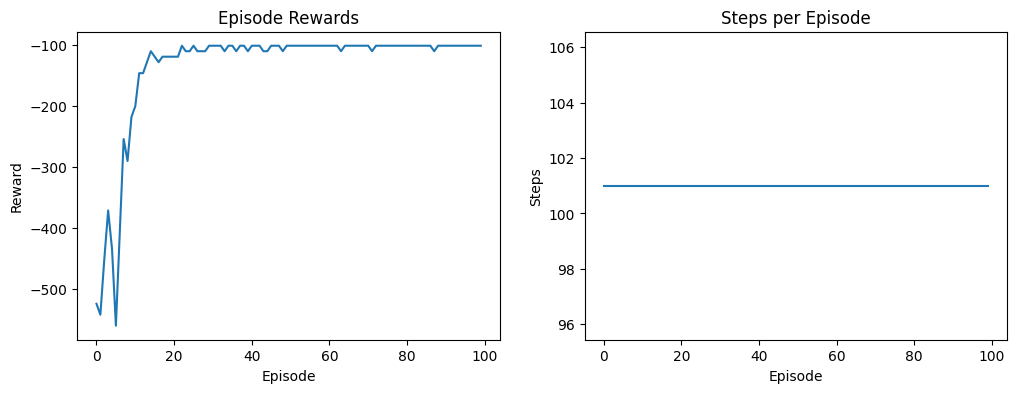

In [31]:
# Plot training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 2, 2)
plt.plot(steps)
plt.title('Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.show()


Visualizing the trained agent's path...


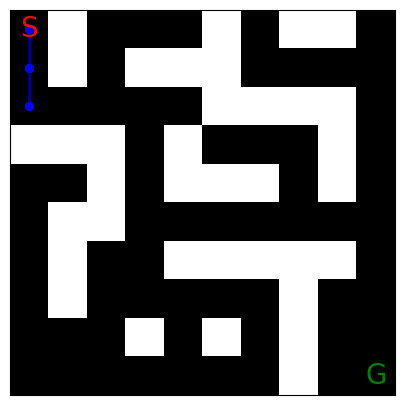

Final path length: 102 steps


In [32]:
# Function to visualize the trained agent's path
def visualize_path(agent, maze):
    state = maze.start_position
    path = [state]
    steps = 0
    
    while True:
        action = agent.get_action(state)
        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        
        if (next_state[0] < 0 or next_state[0] >= maze.maze_height or
            next_state[1] < 0 or next_state[1] >= maze.maze_width or
            maze.maze[next_state[1]][next_state[0]] == 1):
            next_state = state
        
        path.append(next_state)
        state = next_state
        steps += 1
        
        if state == maze.goal_position or steps > 100:
            break
    
    # Visualize the path
    plt.figure(figsize=(5,5))
    plt.imshow(maze.maze, cmap='gray')
    plt.text(maze.start_position[0], maze.start_position[1], 'S', 
            ha='center', va='center', color='red', fontsize=20)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'G', 
            ha='center', va='center', color='green', fontsize=20)
    
    # Plot the path
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, 'b-', linewidth=2, alpha=0.5)
    plt.plot(path_x, path_y, 'b.', markersize=10)
    
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    return path

# Visualize the final path
print("\nVisualizing the trained agent's path...")
final_path = visualize_path(curious_agent, maze)
print(f"Final path length: {len(final_path)} steps")

Testing the trained curious agent...

Testing the trained agent...

Test Run 1/5
Step 1:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 2:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 3:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 4:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 5:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 6:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 7:
Position: (0, 2)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 1.00, Right: 0.00
Step 8:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 9:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 10:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, 

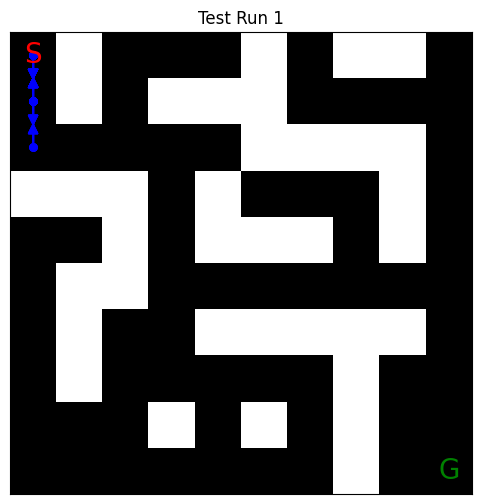


Test Run 2/5
Step 1:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 2:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 3:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 4:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 5:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 6:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 7:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 8:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 9:
Position: (0, 2)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 1.00, Right: 0.00
Step 10:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 11:
Position: (0, 0)
Action Probabilities: Up: 0.0

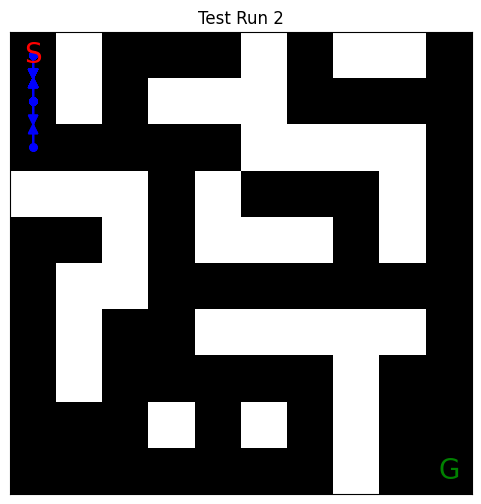


Test Run 3/5
Step 1:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 2:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 3:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 4:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 5:
Position: (0, 2)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 1.00, Right: 0.00
Step 6:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 7:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 8:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 9:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 10:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 11:
Position: (0, 0)
Action Probabilities: Up: 0.0

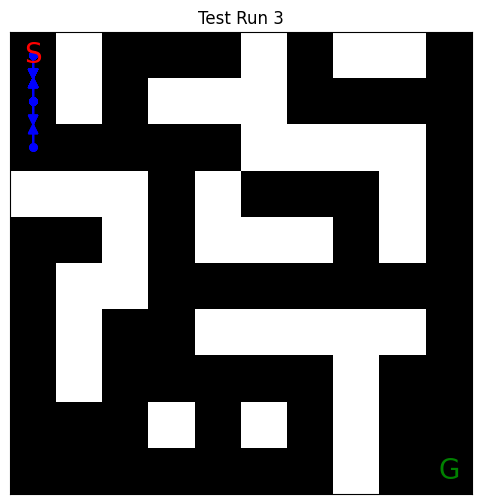


Test Run 4/5
Step 1:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 2:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 3:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 4:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 5:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 6:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 7:
Position: (0, 2)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 1.00, Right: 0.00
Step 8:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 9:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 10:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 11:
Position: (0, 0)
Action Probabilities: Up: 0.0

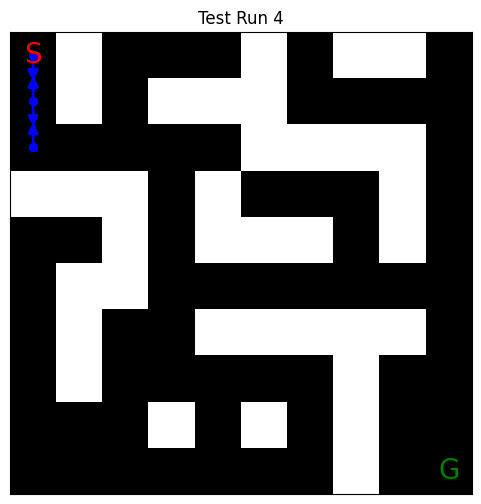


Test Run 5/5
Step 1:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 2:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 3:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 4:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 5:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 6:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 7:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 8:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 9:
Position: (0, 0)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.00, Right: 1.00
Step 10:
Position: (0, 1)
Action Probabilities: Up: 0.00, Down: 0.00, Left: 0.86, Right: 0.14
Step 11:
Position: (0, 0)
Action Probabilities: Up: 0.0

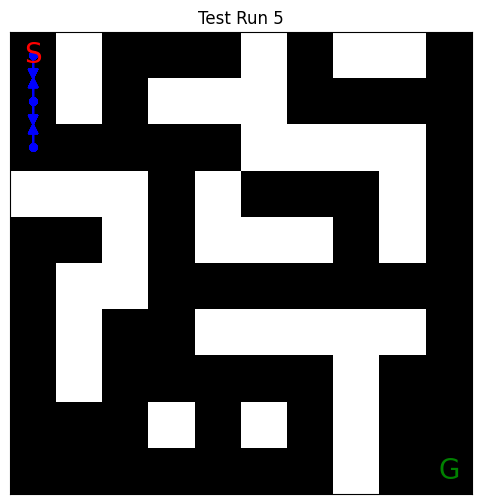


Test Summary:
Average steps to goal: 100.00 ± 0.00
Average total reward: -101.80 ± 3.60
Success rate: 0.0%


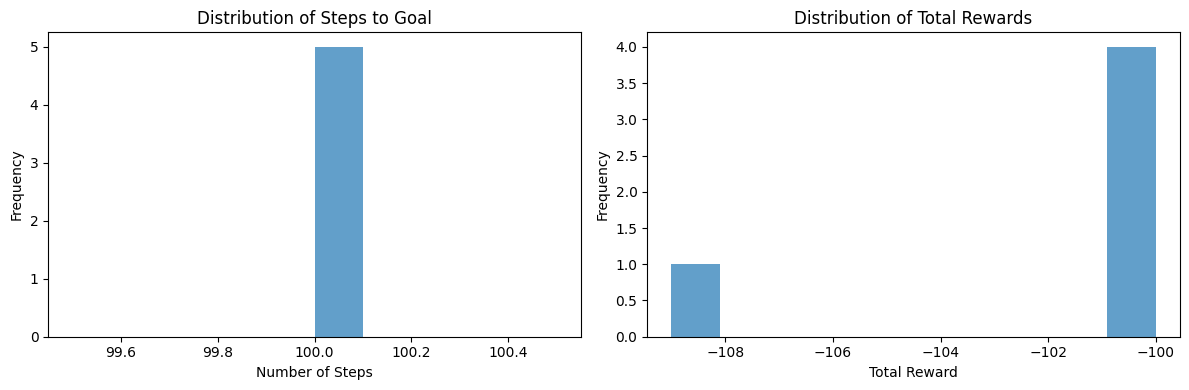

In [33]:
def test_curious_agent(agent, maze, num_tests=5):
    """
    Test the trained agent multiple times and analyze its performance.
    
    Parameters:
    - agent: The trained CuriousActorCriticAgent
    - maze: The maze environment
    - num_tests: Number of test runs to perform
    """
    print("\nTesting the trained agent...")
    
    all_paths = []
    all_rewards = []
    all_steps = []
    
    # Run multiple tests
    for test_num in range(num_tests):
        print(f"\nTest Run {test_num + 1}/{num_tests}")
        state = maze.start_position
        current_path = [state]
        total_reward = 0
        steps = 0
        
        # Keep track of action probabilities for analysis
        action_probs_history = []
        
        while True:
            # Get state tensor and action probabilities
            state_tensor = agent.get_state_tensor(state)
            action_probs, state_value = agent.actor_critic(state_tensor)
            action_probs = action_probs.detach().cpu().numpy()[0]
            
            # Store action probabilities
            action_probs_history.append(action_probs)
            
            # Get action
            action = agent.get_action(state)
            
            # Calculate next state
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Print current decision details
            print(f"Step {steps + 1}:")
            print(f"Position: {state}")
            print(f"Action Probabilities: Up: {action_probs[0]:.2f}, Down: {action_probs[1]:.2f}, "
                  f"Left: {action_probs[2]:.2f}, Right: {action_probs[3]:.2f}")
            
            # Check boundaries and walls
            if (next_state[0] < 0 or next_state[0] >= maze.maze_height or
                next_state[1] < 0 or next_state[1] >= maze.maze_width or
                maze.maze[next_state[1]][next_state[0]] == 1):
                reward = wall_penalty
                next_state = state
            elif next_state == maze.goal_position:
                reward = goal_reward
                current_path.append(next_state)
                total_reward += reward
                steps += 1
                print(f"Goal reached! Total steps: {steps}, Total reward: {total_reward}")
                break
            else:
                reward = step_penalty
                current_path.append(next_state)
            
            total_reward += reward
            steps += 1
            state = next_state
            
            if steps >= 100:  # Maximum steps limit
                print(f"Maximum steps reached. Total reward: {total_reward}")
                break
        
        all_paths.append(current_path)
        all_rewards.append(total_reward)
        all_steps.append(steps)
        
        # Visualize the current test run
        visualize_test_run(maze, current_path, test_num + 1)
    
    # Print summary statistics
    print("\nTest Summary:")
    print(f"Average steps to goal: {np.mean(all_steps):.2f} ± {np.std(all_steps):.2f}")
    print(f"Average total reward: {np.mean(all_rewards):.2f} ± {np.std(all_rewards):.2f}")
    print(f"Success rate: {sum([r >= goal_reward for r in all_rewards]) / num_tests * 100:.1f}%")
    
    return all_paths, all_rewards, all_steps

def visualize_test_run(maze, path, test_num):
    """
    Visualize a single test run with the path taken by the agent.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(maze.maze, cmap='gray')
    
    # Plot start and goal positions
    plt.text(maze.start_position[0], maze.start_position[1], 'S', 
            ha='center', va='center', color='red', fontsize=20)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'G', 
            ha='center', va='center', color='green', fontsize=20)
    
    # Plot the path with direction arrows
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, 'b-', linewidth=2, alpha=0.5)
    plt.plot(path_x, path_y, 'b.', markersize=10)
    
    # Add arrows to show direction of movement
    for i in range(len(path) - 1):
        dx = path[i+1][0] - path[i][0]
        dy = path[i+1][1] - path[i][1]
        plt.arrow(path[i][0], path[i][1], dx*0.3, dy*0.3, 
                 head_width=0.2, head_length=0.2, fc='blue', ec='blue', alpha=0.5)
    
    plt.title(f'Test Run {test_num}')
    plt.xticks([]), plt.yticks([])
    plt.show()

# To test the trained agent:
print("Testing the trained curious agent...")
test_paths, test_rewards, test_steps = test_curious_agent(curious_agent, maze, num_tests=5)

# Plot the distribution of test results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(test_steps, bins=10, alpha=0.7)
plt.title('Distribution of Steps to Goal')
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_rewards, bins=10, alpha=0.7)
plt.title('Distribution of Total Rewards')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

0000000000

Episode 100/1000, Avg Reward: -311.63, Avg Steps: 93.45, Best Steps: 34
Episode 200/1000, Avg Reward: -141.18, Avg Steps: 65.01, Best Steps: 25
Episode 300/1000, Avg Reward: -96.73, Avg Steps: 55.17, Best Steps: 25
Episode 400/1000, Avg Reward: -2.22, Avg Steps: 32.45, Best Steps: 18
Episode 500/1000, Avg Reward: 12.15, Avg Steps: 28.76, Best Steps: 18
Episode 600/1000, Avg Reward: 34.04, Avg Steps: 22.62, Best Steps: 18
Episode 700/1000, Avg Reward: 35.15, Avg Steps: 22.51, Best Steps: 18
Episode 800/1000, Avg Reward: 40.52, Avg Steps: 21.52, Best Steps: 18
Episode 900/1000, Avg Reward: 41.21, Avg Steps: 21.10, Best Steps: 18
Episode 1000/1000, Avg Reward: 44.92, Avg Steps: 20.15, Best Steps: 18


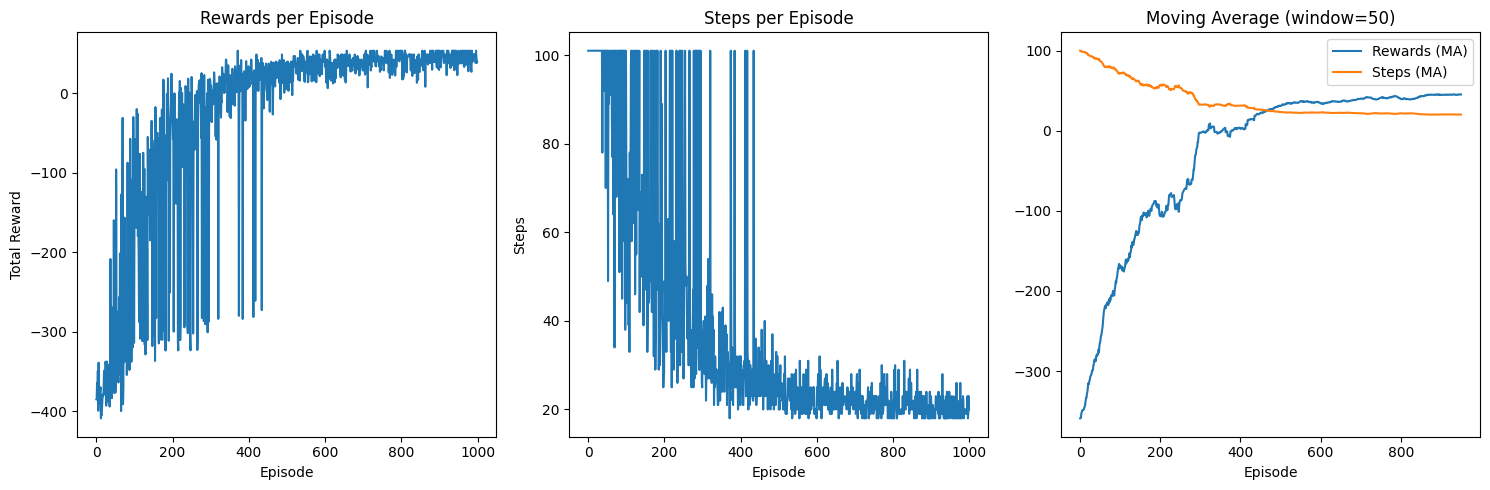

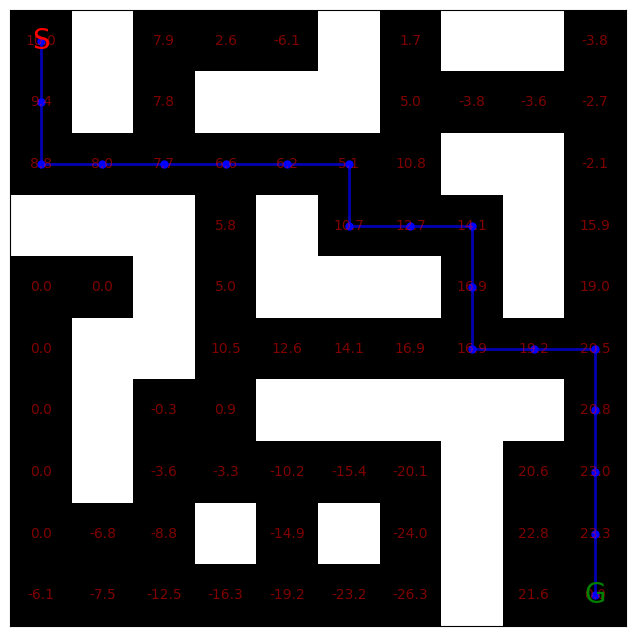

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque

class OptimizedMaze:
    def __init__(self, maze, start_position, goal_position):
        self.maze = maze
        self.maze_height = maze.shape[0]
        self.maze_width = maze.shape[1]
        self.start_position = start_position
        self.goal_position = goal_position
        
        # Pre-compute distances for reward shaping
        self.distance_map = self._compute_distance_map()
    
    def _compute_distance_map(self):
        """Compute Manhattan distance from each cell to the goal"""
        distance_map = np.zeros((self.maze_height, self.maze_width))
        for i in range(self.maze_height):
            for j in range(self.maze_width):
                if self.maze[i][j] != 1:  # If not a wall
                    distance_map[i][j] = abs(i - self.goal_position[1]) + abs(j - self.goal_position[0])
        return distance_map

    def show_maze(self, path=None, q_values=None):
        plt.figure(figsize=(8, 8))
        plt.imshow(self.maze, cmap='gray')
        
        # Plot path if provided
        if path:
            path = np.array(path)
            plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=2, alpha=0.7)
            plt.plot(path[:, 0], path[:, 1], 'b.', markersize=10)
        
        # Plot Q-values if provided
        if q_values is not None:
            for i in range(self.maze_height):
                for j in range(self.maze_width):
                    if self.maze[i][j] != 1:  # If not a wall
                        max_q = np.max(q_values[j, i])
                        plt.text(j, i, f'{max_q:.1f}', ha='center', va='center', color='red', alpha=0.5)
        
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()

class ImprovedQLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.95, exploration_start=1.0, exploration_end=0.05, num_episodes=1000):
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes
        
        # Experience replay buffer
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 32
        
        # Separate target network for stability
        self.target_q_table = self.q_table.copy()
        self.target_update_frequency = 100
        
        # Prioritized sweeping parameters
        self.priority_threshold = 0.1
        self.priority_queue = []
    
    def get_exploration_rate(self, current_episode):
        # Slower exponential decay of exploration rate
        return self.exploration_end + (self.exploration_start - self.exploration_end) * \
               np.exp(-3 * current_episode / self.num_episodes)
    
    def get_action(self, state, current_episode):
        exploration_rate = self.get_exploration_rate(current_episode)
        
        if np.random.rand() < exploration_rate:
            return np.random.randint(4)
        
        # Boltzmann exploration (softmax) for better action selection
        q_values = self.q_table[state]
        temperature = max(0.1, 1.0 - current_episode / self.num_episodes)
        exp_q = np.exp(q_values / temperature)
        probs = exp_q / np.sum(exp_q)
        return np.random.choice(4, p=probs)
    
    def update_q_table(self, state, action, next_state, reward, done):
        # Store experience in replay buffer
        self.replay_buffer.append((state, action, next_state, reward, done))
        
        # Perform experience replay
        if len(self.replay_buffer) >= self.batch_size:
            self._experience_replay()
    
    def _experience_replay(self):
        # Sample batch from replay buffer
        batch = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)
        for idx in batch:
            state, action, next_state, reward, done = self.replay_buffer[idx]
            
            # Double Q-learning update
            if not done:
                next_action = np.argmax(self.q_table[next_state])
                next_q = self.target_q_table[next_state][next_action]
                target = reward + self.discount_factor * next_q
            else:
                target = reward
            
            # Update Q-value
            current_q = self.q_table[state][action]
            self.q_table[state][action] += self.learning_rate * (target - current_q)
            
            # Add to priority queue if error is significant
            error = abs(target - current_q)
            if error > self.priority_threshold:
                self.priority_queue.append((error, state, action))
    
    def update_target_network(self):
        self.target_q_table = self.q_table.copy()

def enhanced_reward_function(state, next_state, maze, done, steps):
    """Enhanced reward function with distance-based shaping"""
    if done:
        return 500 / (steps + 1)  # Goal reached with steps-based reward
    
    if next_state == state:  # Hit wall or invalid move
        return -5
    
    # Distance-based reward shaping
    current_distance = maze.distance_map[state[1]][state[0]]
    next_distance = maze.distance_map[next_state[1]][next_state[0]]
    distance_reward = 2 * (current_distance - next_distance)  # Increased weight
    
    # Smaller time penalty
    time_penalty = -0.05 * steps
    
    # Add small negative reward to encourage faster goal-reaching
    move_penalty = -0.1
    
    return distance_reward + time_penalty + move_penalty

def train_improved_agent(agent, maze, num_episodes=1000):
    episode_rewards = []
    episode_steps = []
    best_episode_steps = float('inf')
    best_path = None
    
    for episode in range(num_episodes):
        current_state = maze.start_position
        episode_reward = 0
        steps = 0
        path = [current_state]
        
        while True:
            action = agent.get_action(current_state, episode)
            next_state = (
                current_state[0] + actions[action][0],
                current_state[1] + actions[action][1]
            )
            
            # Check if move is valid
            if (next_state[0] < 0 or next_state[0] >= maze.maze_width or
                next_state[1] < 0 or next_state[1] >= maze.maze_height or
                maze.maze[next_state[1]][next_state[0]] == 1):
                next_state = current_state
            
            done = next_state == maze.goal_position
            reward = enhanced_reward_function(current_state, next_state, maze, done, steps)
            
            agent.update_q_table((current_state[0], current_state[1]), action,
                               (next_state[0], next_state[1]), reward, done)
            
            current_state = next_state
            episode_reward += reward
            steps += 1
            path.append(current_state)
            
            if done or steps > 100:  # Add step limit to prevent infinite loops
                break
        
        # Update target network periodically
        if episode % agent.target_update_frequency == 0:
            agent.update_target_network()
        
        # Store best path
        if done and steps < best_episode_steps:
            best_episode_steps = steps
            best_path = path
        
        episode_rewards.append(episode_reward)
        episode_steps.append(steps)
        
        # Print progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{num_episodes}, "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Best Steps: {best_episode_steps}")
    
    return episode_rewards, episode_steps, best_path

def visualize_training_results(episode_rewards, episode_steps):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(episode_rewards)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 3, 2)
    plt.plot(episode_steps)
    plt.title('Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    
    # Plot moving averages
    window_size = 50
    plt.subplot(1, 3, 3)
    plt.plot(np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid'),
             label='Rewards (MA)')
    plt.plot(np.convolve(episode_steps, np.ones(window_size)/window_size, mode='valid'),
             label='Steps (MA)')
    plt.title(f'Moving Average (window={window_size})')
    plt.xlabel('Episode')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
maze = OptimizedMaze(maze_layout, (0, 0), (9, 9))
agent = ImprovedQLearningAgent(maze)
rewards, steps, best_path = train_improved_agent(agent, maze, num_episodes=1000)
visualize_training_results(rewards, steps)
maze.show_maze(path=best_path, q_values=agent.q_table)

-------------------------------------------------------------------------------------

Training agent...
Episode 100/1000, Avg Reward: -322.82, Avg Steps: 95.46, Best Steps: 45
Episode 200/1000, Avg Reward: -176.43, Avg Steps: 71.72, Best Steps: 25
Episode 300/1000, Avg Reward: -126.84, Avg Steps: 61.95, Best Steps: 24
Episode 400/1000, Avg Reward: -31.99, Avg Steps: 39.84, Best Steps: 19
Episode 500/1000, Avg Reward: 21.38, Avg Steps: 26.27, Best Steps: 18
Episode 600/1000, Avg Reward: 29.77, Avg Steps: 24.32, Best Steps: 18
Episode 700/1000, Avg Reward: 34.64, Avg Steps: 22.78, Best Steps: 18
Episode 800/1000, Avg Reward: 41.11, Avg Steps: 21.12, Best Steps: 18
Episode 900/1000, Avg Reward: 42.77, Avg Steps: 20.82, Best Steps: 18
Episode 1000/1000, Avg Reward: 44.85, Avg Steps: 20.21, Best Steps: 18

Testing trained agent...


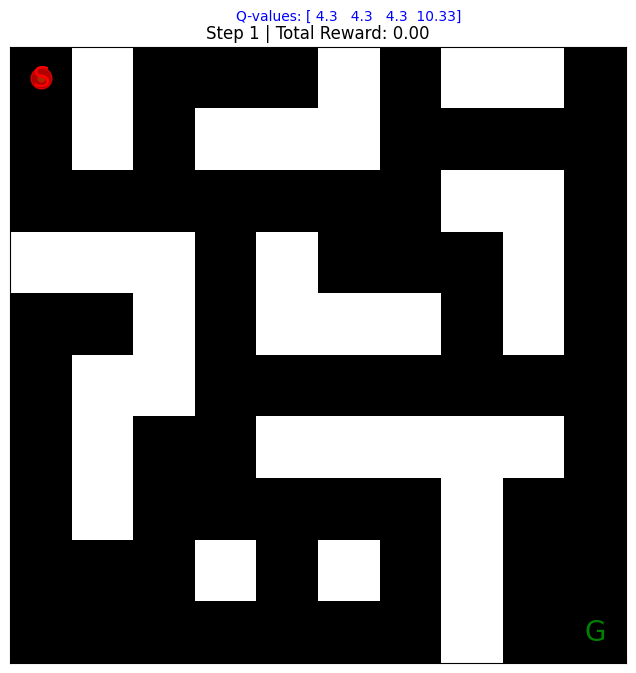

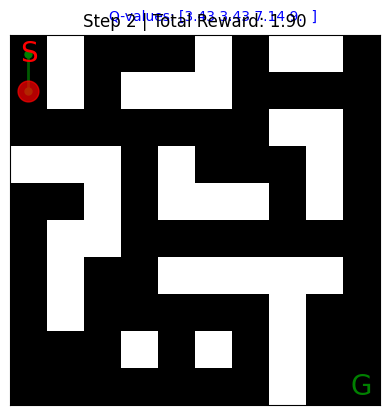

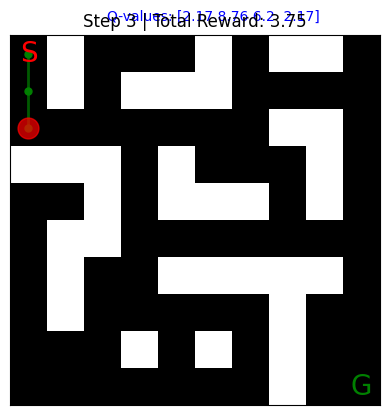

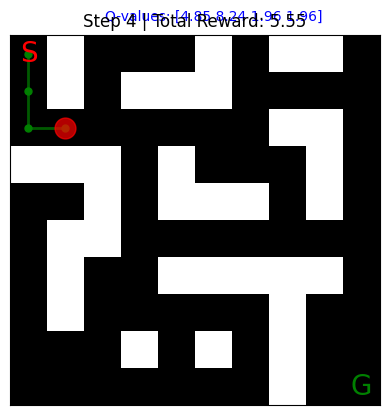

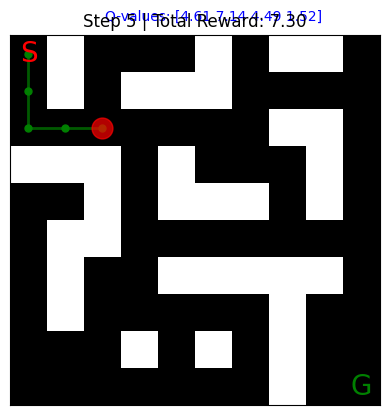

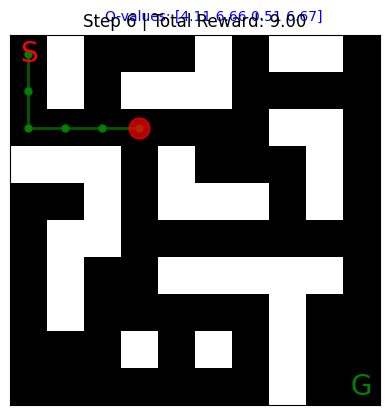

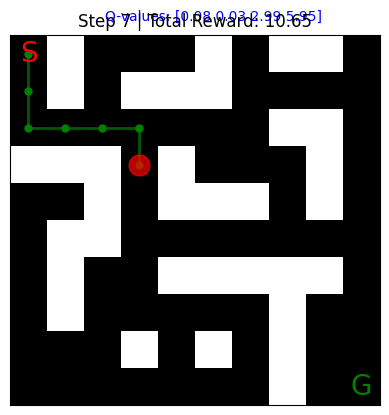

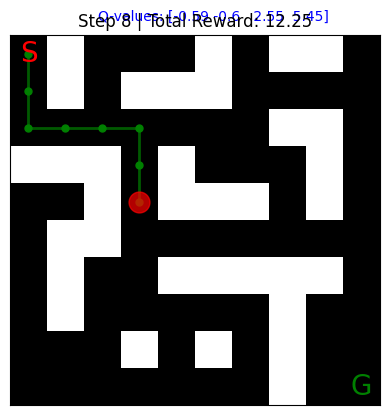

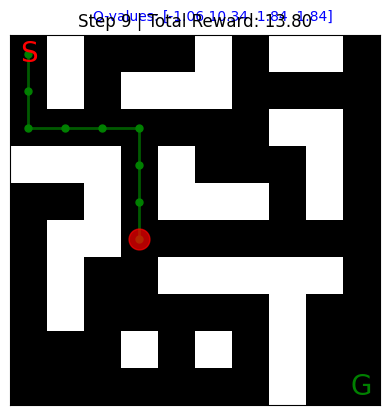

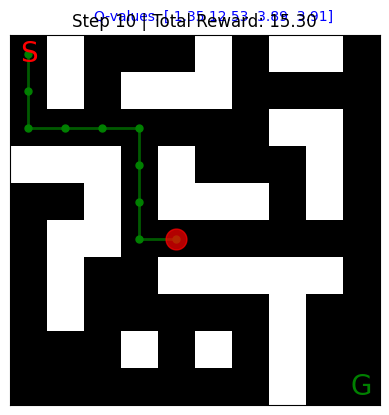

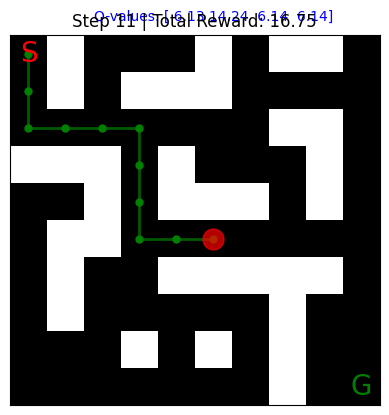

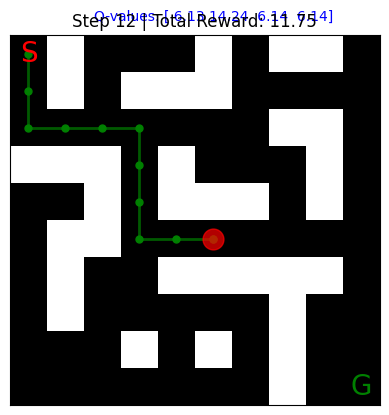

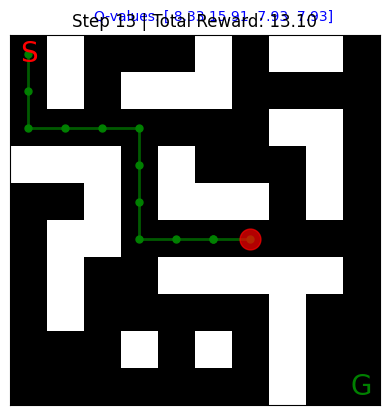

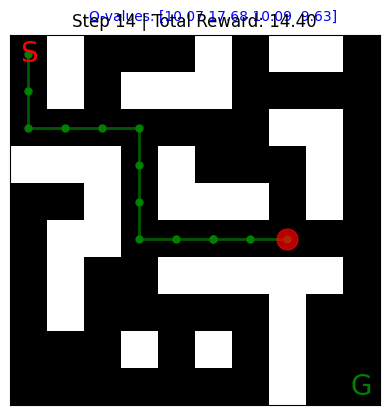

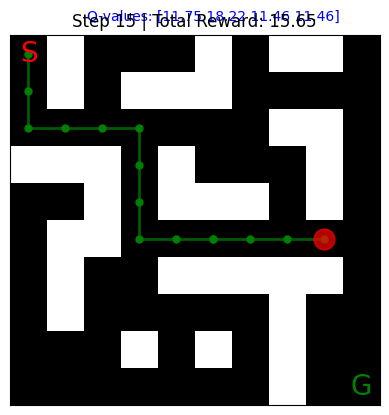

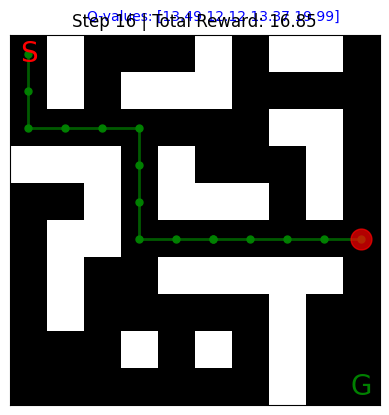

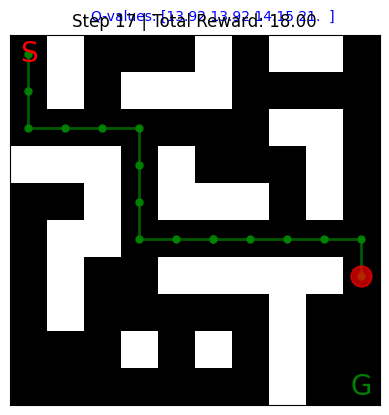

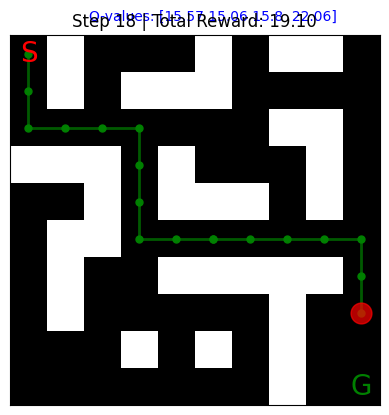

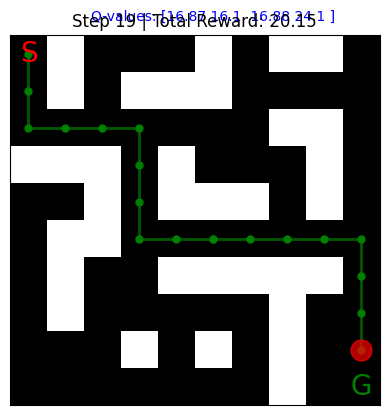

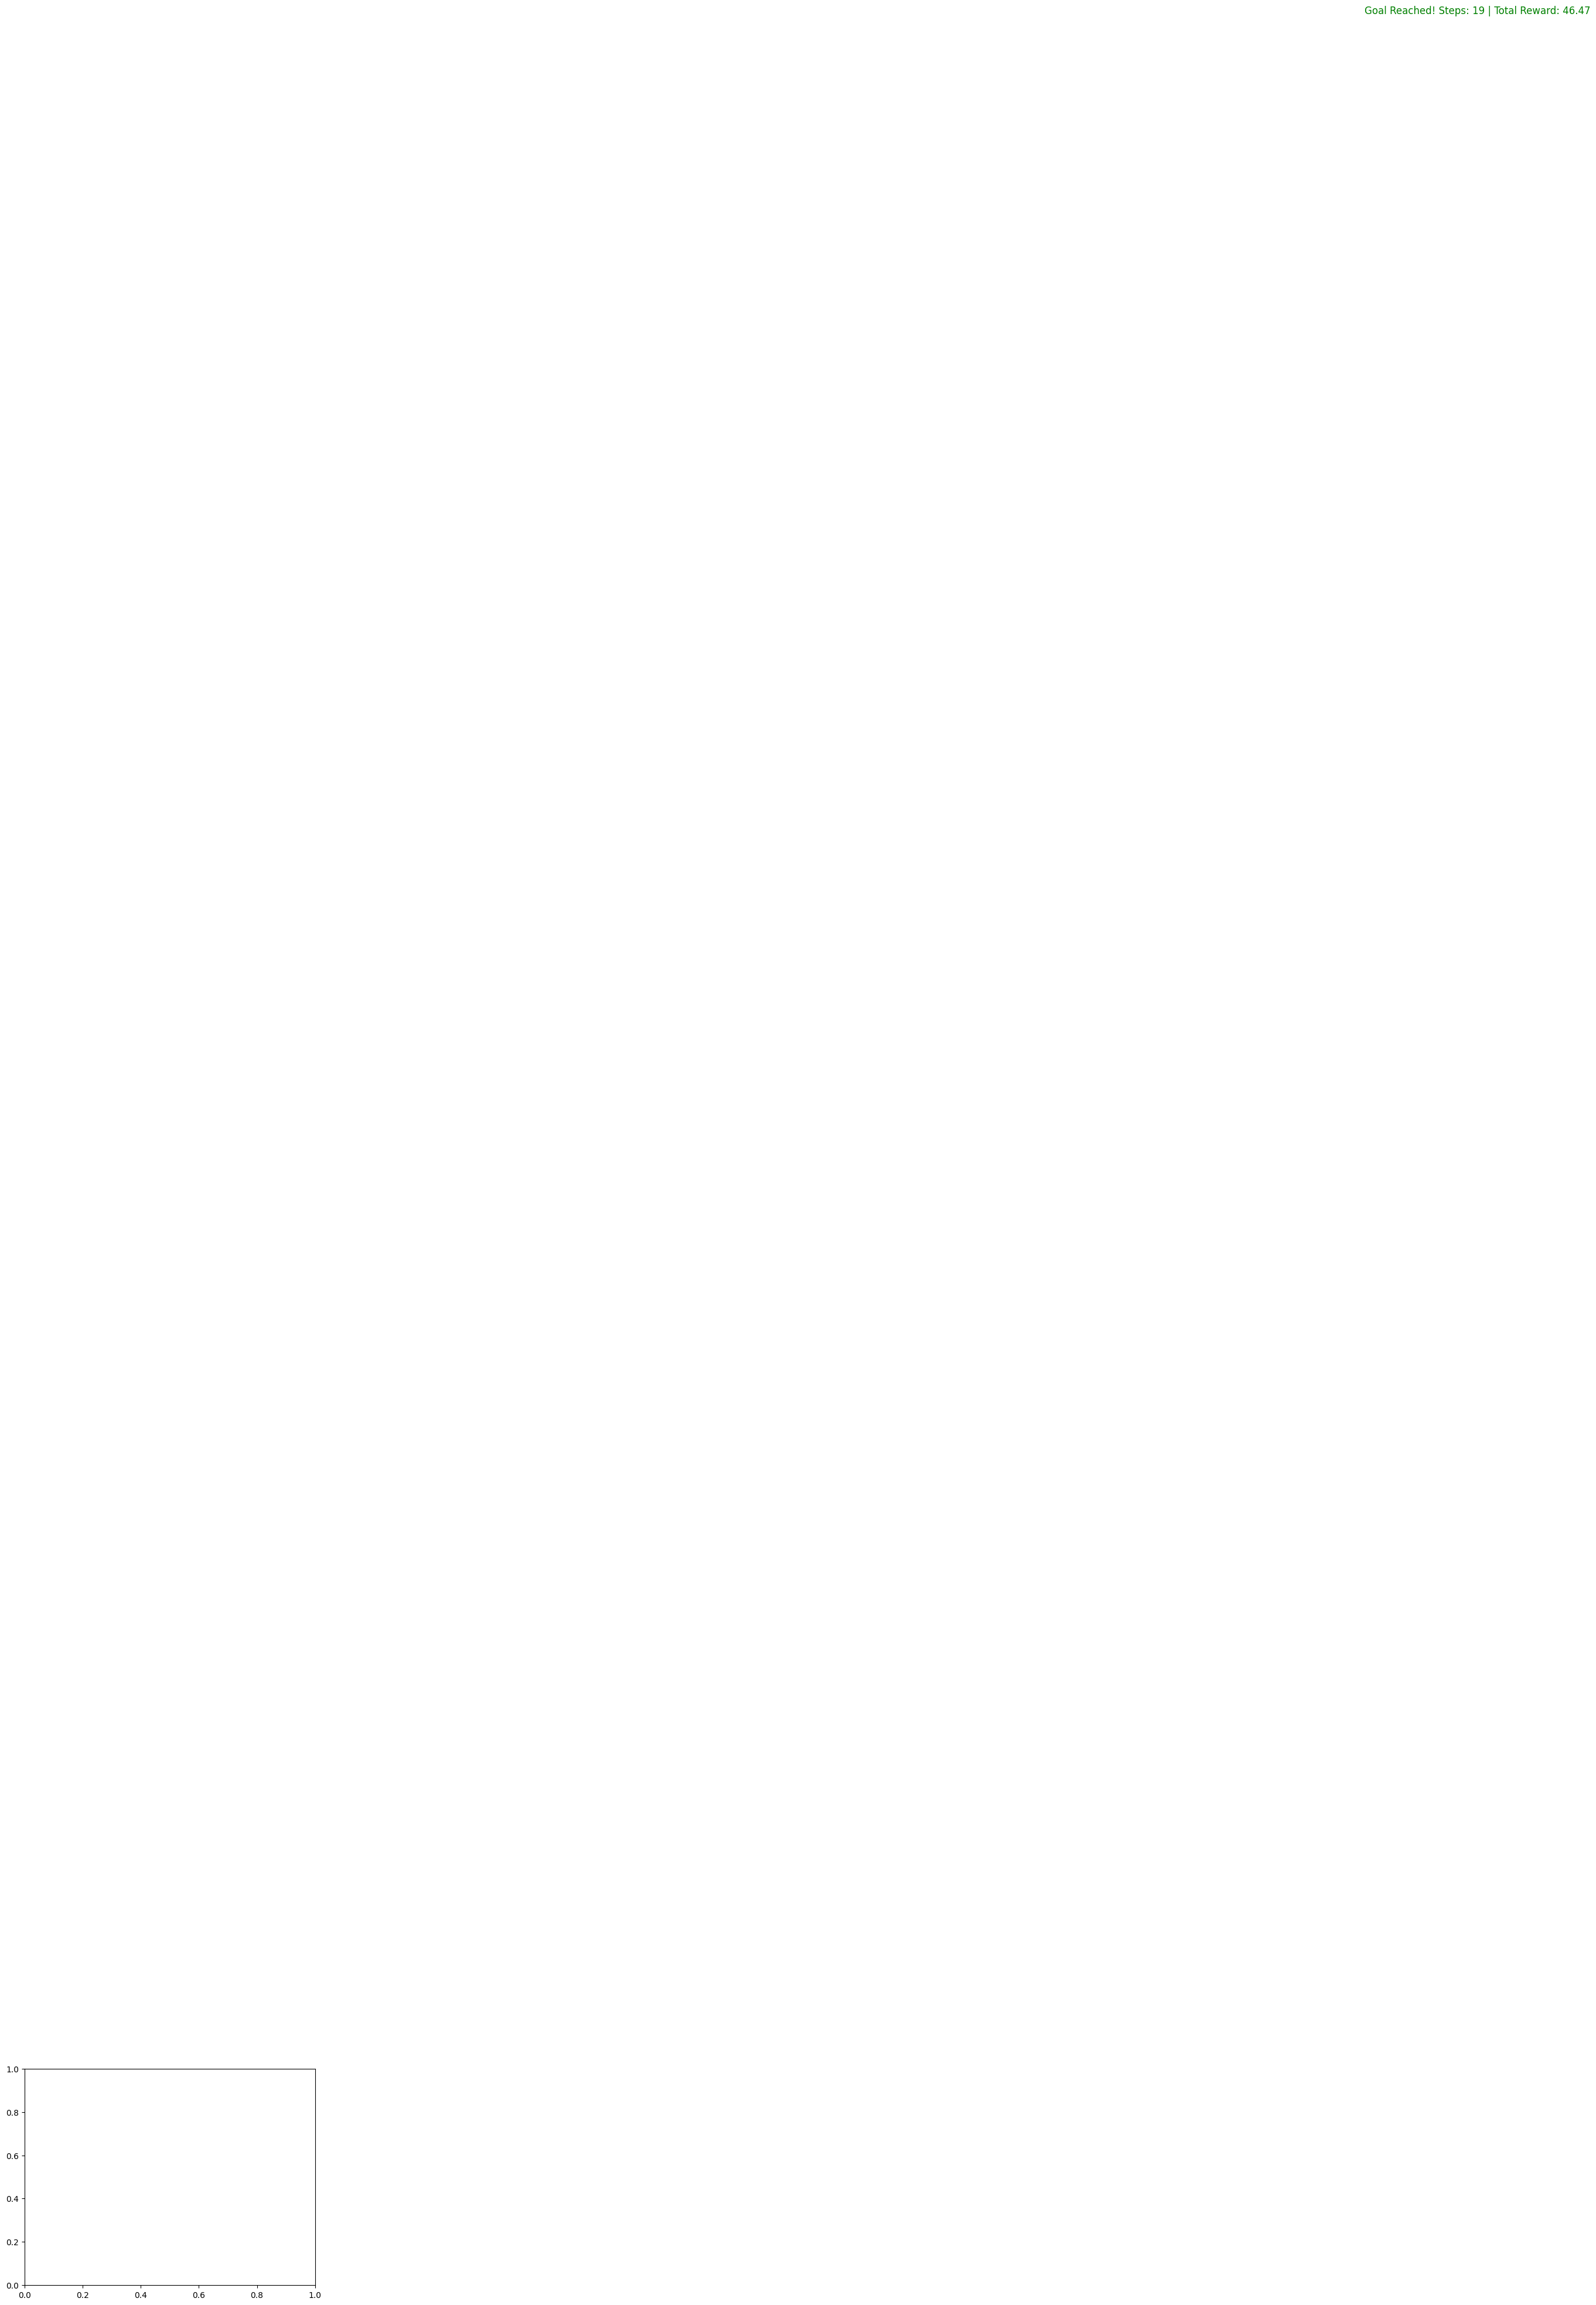

Steps taken: 19
Total reward: 46.47


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque

class OptimizedMaze:
    def __init__(self, maze, start_position, goal_position):
        self.maze = maze
        self.maze_height = maze.shape[0]
        self.maze_width = maze.shape[1]
        self.start_position = start_position
        self.goal_position = goal_position
        
        # Pre-compute distances for reward shaping
        self.distance_map = self._compute_distance_map()
    
    def _compute_distance_map(self):
        """Compute Manhattan distance from each cell to the goal"""
        distance_map = np.zeros((self.maze_height, self.maze_width))
        for i in range(self.maze_height):
            for j in range(self.maze_width):
                if self.maze[i][j] != 1:  # If not a wall
                    distance_map[i][j] = abs(i - self.goal_position[1]) + abs(j - self.goal_position[0])
        return distance_map

    def show_maze(self, path=None, q_values=None):
        plt.figure(figsize=(8, 8))
        plt.imshow(self.maze, cmap='gray')
        
        # Plot path if provided
        if path:
            path = np.array(path)
            plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=2, alpha=0.7)
            plt.plot(path[:, 0], path[:, 1], 'b.', markersize=10)
        
        # Plot Q-values if provided
        if q_values is not None:
            for i in range(self.maze_height):
                for j in range(self.maze_width):
                    if self.maze[i][j] != 1:  # If not a wall
                        max_q = np.max(q_values[j, i])
                        plt.text(j, i, f'{max_q:.1f}', ha='center', va='center', color='red', alpha=0.5)
        
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()

class ImprovedQLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.95, exploration_start=1.0, exploration_end=0.05, num_episodes=1000):
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes
        
        # Experience replay buffer
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 32
        
        # Separate target network for stability
        self.target_q_table = self.q_table.copy()
        self.target_update_frequency = 100
        
        # Prioritized sweeping parameters
        self.priority_threshold = 0.1
        self.priority_queue = []
    
    def get_exploration_rate(self, current_episode):
        # Slower exponential decay of exploration rate
        return self.exploration_end + (self.exploration_start - self.exploration_end) * \
               np.exp(-3 * current_episode / self.num_episodes)
    
    def get_action(self, state, current_episode):
        exploration_rate = self.get_exploration_rate(current_episode)
        
        if np.random.rand() < exploration_rate:
            return np.random.randint(4)
        
        # Boltzmann exploration (softmax) for better action selection
        q_values = self.q_table[state]
        temperature = max(0.1, 1.0 - current_episode / self.num_episodes)
        exp_q = np.exp(q_values / temperature)
        probs = exp_q / np.sum(exp_q)
        return np.random.choice(4, p=probs)
    
    def update_q_table(self, state, action, next_state, reward, done):
        # Store experience in replay buffer
        self.replay_buffer.append((state, action, next_state, reward, done))
        
        # Perform experience replay
        if len(self.replay_buffer) >= self.batch_size:
            self._experience_replay()
    
    def _experience_replay(self):
        # Sample batch from replay buffer
        batch = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)
        for idx in batch:
            state, action, next_state, reward, done = self.replay_buffer[idx]
            
            # Double Q-learning update
            if not done:
                next_action = np.argmax(self.q_table[next_state])
                next_q = self.target_q_table[next_state][next_action]
                target = reward + self.discount_factor * next_q
            else:
                target = reward
            
            # Update Q-value
            current_q = self.q_table[state][action]
            self.q_table[state][action] += self.learning_rate * (target - current_q)
            
            # Add to priority queue if error is significant
            error = abs(target - current_q)
            if error > self.priority_threshold:
                self.priority_queue.append((error, state, action))
    
    def update_target_network(self):
        self.target_q_table = self.q_table.copy()

def enhanced_reward_function(state, next_state, maze, done, steps):
    """Enhanced reward function with distance-based shaping"""
    if done:
        return 500 / (steps + 1)  # Goal reached with steps-based reward
    
    if next_state == state:  # Hit wall or invalid move
        return -5
    
    # Distance-based reward shaping
    current_distance = maze.distance_map[state[1]][state[0]]
    next_distance = maze.distance_map[next_state[1]][next_state[0]]
    distance_reward = 2 * (current_distance - next_distance)  # Increased weight
    
    # Smaller time penalty
    time_penalty = -0.05 * steps
    
    # Add small negative reward to encourage faster goal-reaching
    move_penalty = -0.1
    
    return distance_reward + time_penalty + move_penalty

def train_improved_agent(agent, maze, num_episodes=1000):
    episode_rewards = []
    episode_steps = []
    best_episode_steps = float('inf')
    best_path = None
    
    for episode in range(num_episodes):
        current_state = maze.start_position
        episode_reward = 0
        steps = 0
        path = [current_state]
        
        while True:
            action = agent.get_action(current_state, episode)
            next_state = (
                current_state[0] + actions[action][0],
                current_state[1] + actions[action][1]
            )
            
            # Check if move is valid
            if (next_state[0] < 0 or next_state[0] >= maze.maze_width or
                next_state[1] < 0 or next_state[1] >= maze.maze_height or
                maze.maze[next_state[1]][next_state[0]] == 1):
                next_state = current_state
            
            done = next_state == maze.goal_position
            reward = enhanced_reward_function(current_state, next_state, maze, done, steps)
            
            agent.update_q_table((current_state[0], current_state[1]), action,
                               (next_state[0], next_state[1]), reward, done)
            
            current_state = next_state
            episode_reward += reward
            steps += 1
            path.append(current_state)
            
            if done or steps > 100:  # Add step limit to prevent infinite loops
                break
        
        # Update target network periodically
        if episode % agent.target_update_frequency == 0:
            agent.update_target_network()
        
        # Store best path
        if done and steps < best_episode_steps:
            best_episode_steps = steps
            best_path = path
        
        episode_rewards.append(episode_reward)
        episode_steps.append(steps)
        
        # Print progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{num_episodes}, "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Best Steps: {best_episode_steps}")
    
    return episode_rewards, episode_steps, best_path

def visualize_untrained_agent(maze, agent):
    """Visualize how an untrained agent moves through the maze"""
    current_state = maze.start_position
    path = [current_state]
    steps = 0
    
    plt.ion()  # Turn on interactive mode
    fig = plt.figure(figsize=(8, 8))
    
    while steps < 100:  # Limit steps to prevent infinite loops
        plt.clf()  # Clear the current figure
        
        # Show the maze
        plt.imshow(maze.maze, cmap='gray')
        
        # Plot the path taken so far
        path_array = np.array(path)
        plt.plot(path_array[:, 0], path_array[:, 1], 'b-', linewidth=2, alpha=0.7)
        plt.plot(path_array[:, 0], path_array[:, 1], 'b.', markersize=10)
        
        # Mark start and goal
        plt.text(maze.start_position[0], maze.start_position[1], 'S', 
                ha='center', va='center', color='red', fontsize=20)
        plt.text(maze.goal_position[0], maze.goal_position[1], 'G', 
                ha='center', va='center', color='green', fontsize=20)
        
        # Mark current position
        plt.plot(current_state[0], current_state[1], 'ro', markersize=15, alpha=0.7)
        
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Step {steps + 1}')
        plt.pause(0.5)  # Pause to show movement
        
        # Get random action (untrained agent)
        action = agent.get_action(current_state, 0)  # episode 0 for maximum exploration
        next_state = (
            current_state[0] + actions[action][0],
            current_state[1] + actions[action][1]
        )
        
        # Check if move is valid
        if (next_state[0] < 0 or next_state[0] >= maze.maze_width or
            next_state[1] < 0 or next_state[1] >= maze.maze_height or
            maze.maze[next_state[1]][next_state[0]] == 1):
            next_state = current_state
            
        current_state = next_state
        path.append(current_state)
        steps += 1
        
        # Check if goal is reached
        if current_state == maze.goal_position:
            plt.text(maze.maze_width/2, -1, 'Goal Reached!', 
                    ha='center', va='center', color='green', fontsize=16)
            plt.pause(2)
            break
    
    if current_state != maze.goal_position:
        plt.text(maze.maze_width/2, -1, 'Failed to reach goal', 
                ha='center', va='center', color='red', fontsize=16)
    
    plt.ioff()  # Turn off interactive mode
    plt.show()
    return steps, path

def visualize_trained_agent(maze, agent):
    """Visualize how a trained agent moves through the maze"""
    current_state = maze.start_position
    path = [current_state]
    steps = 0
    total_reward = 0
    
    plt.ion()  # Turn on interactive mode
    fig = plt.figure(figsize=(8, 8))
    
    while steps < 100:  # Limit steps to prevent infinite loops
        plt.clf()  # Clear the current figure
        
        # Show the maze
        plt.imshow(maze.maze, cmap='gray')
        
        # Plot the path taken so far
        path_array = np.array(path)
        plt.plot(path_array[:, 0], path_array[:, 1], 'g-', linewidth=2, alpha=0.7)
        plt.plot(path_array[:, 0], path_array[:, 1], 'g.', markersize=10)
        
        # Mark start and goal
        plt.text(maze.start_position[0], maze.start_position[1], 'S', 
                ha='center', va='center', color='red', fontsize=20)
        plt.text(maze.goal_position[0], maze.goal_position[1], 'G', 
                ha='center', va='center', color='green', fontsize=20)
        
        # Mark current position
        plt.plot(current_state[0], current_state[1], 'ro', markersize=15, alpha=0.7)
        
        # Show Q-values for current state
        q_values = agent.q_table[current_state]
        plt.text(maze.maze_width/2, -1, f'Q-values: {q_values.round(2)}', 
                ha='center', va='center', color='blue', fontsize=10)
        
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Step {steps + 1} | Total Reward: {total_reward:.2f}')
        plt.pause(0.5)  # Pause to show movement
        
        # Get action from trained agent
        action = agent.get_action(current_state, agent.num_episodes)  # Use final episode for exploitation
        next_state = (
            current_state[0] + actions[action][0],
            current_state[1] + actions[action][1]
        )
        
        # Check if move is valid
        if (next_state[0] < 0 or next_state[0] >= maze.maze_width or
            next_state[1] < 0 or next_state[1] >= maze.maze_height or
            maze.maze[next_state[1]][next_state[0]] == 1):
            next_state = current_state
            
        # Calculate reward
        reward = enhanced_reward_function(current_state, next_state, maze, 
                                        next_state == maze.goal_position, steps)
        total_reward += reward
        
        current_state = next_state
        path.append(current_state)
        steps += 1
        
        # Check if goal is reached
        if current_state == maze.goal_position:
            plt.text(maze.maze_width/2, maze.maze_height + 0.5, 
                    f'Goal Reached! Steps: {steps} | Total Reward: {total_reward:.2f}', 
                    ha='center', va='center', color='green', fontsize=12)
            plt.pause(2)
            break
    
    if current_state != maze.goal_position:
        plt.text(maze.maze_width/2, maze.maze_height + 0.5, 
                f'Failed to reach goal | Steps: {steps} | Total Reward: {total_reward:.2f}', 
                ha='center', va='center', color='red', fontsize=12)
    
    plt.ioff()  # Turn off interactive mode
    plt.show()
    
    return steps, path, total_reward

def compare_agent_performance(maze, agent):
    """Compare untrained vs trained agent performance"""
    print("\nTesting Untrained Agent:")
    untrained_steps, untrained_path = visualize_untrained_agent(maze, agent)
    
    print("\nTraining Agent...")
    rewards, steps, best_path = train_improved_agent(agent, maze, num_episodes=1000)
    visualize_training_results(rewards, steps)
    
    print("\nTesting Trained Agent:")
    trained_steps, trained_path, total_reward = visualize_trained_agent(maze, agent)
    
    print("\nPerformance Comparison:")
    print(f"Untrained Agent Steps: {untrained_steps}")
    print(f"Trained Agent Steps: {trained_steps}")
    print(f"Improvement: {((untrained_steps - trained_steps) / untrained_steps * 100):.2f}%")
    print(f"Final Reward: {total_reward:.2f}")
    
    return untrained_path, trained_path

def visualize_training_results(episode_rewards, episode_steps):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(episode_rewards)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 3, 2)
    plt.plot(episode_steps)
    plt.title('Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    
    # Plot moving averages
    window_size = 50
    plt.subplot(1, 3, 3)
    plt.plot(np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid'),
             label='Rewards (MA)')
    plt.plot(np.convolve(episode_steps, np.ones(window_size)/window_size, mode='valid'),
             label='Steps (MA)')
    plt.title(f'Moving Average (window={window_size})')
    plt.xlabel('Episode')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Create maze and agent
maze = OptimizedMaze(maze_layout, (0, 0), (9, 9))
agent = ImprovedQLearningAgent(maze)

# Train the agent
print("Training agent...")
rewards, steps, best_path = train_improved_agent(agent, maze, num_episodes=1000)

# Test trained agent
print("\nTesting trained agent...")
steps, path, total_reward = visualize_trained_agent(maze, agent)
print(f"Steps taken: {steps}")
print(f"Total reward: {total_reward:.2f}")


Testing Untrained Agent:


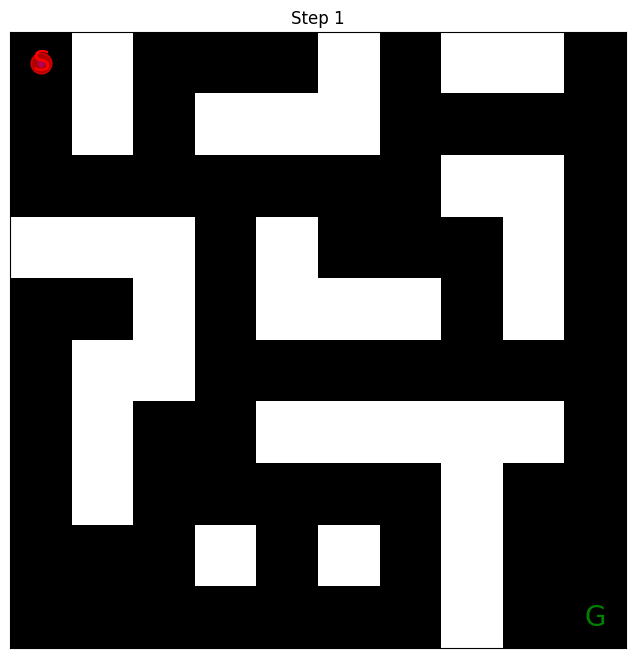

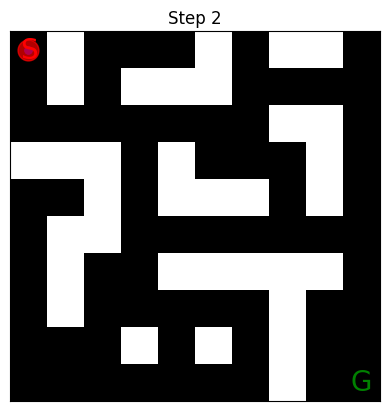

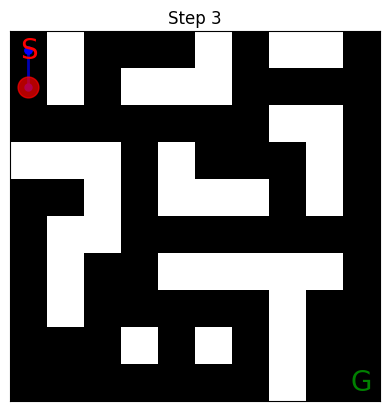

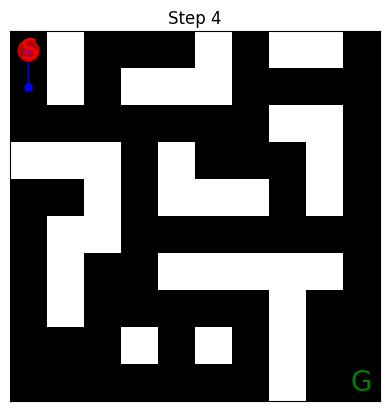

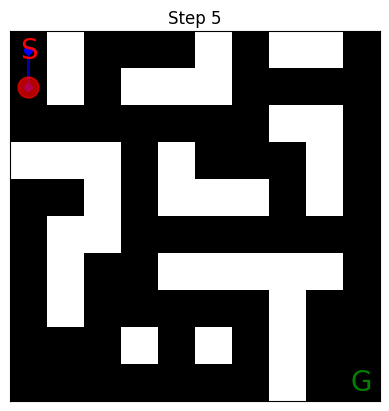

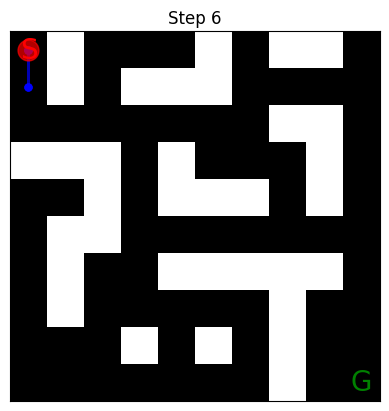

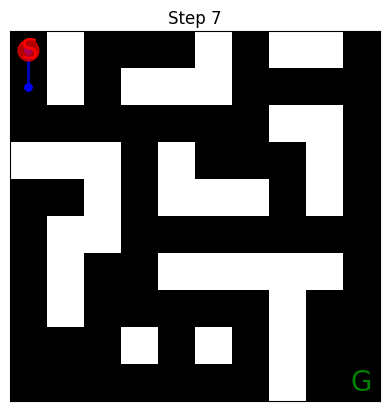

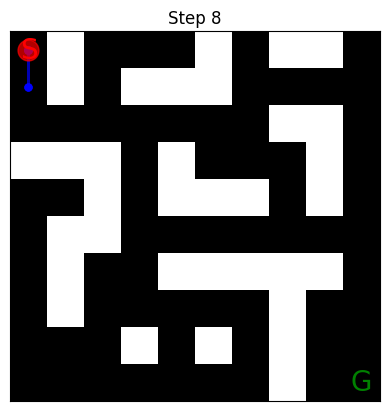

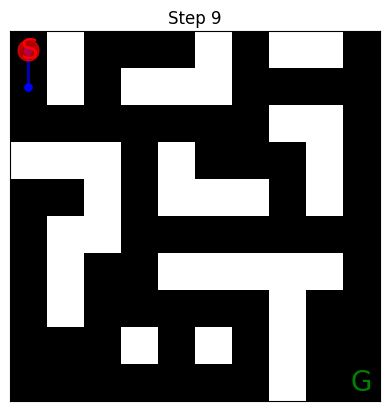

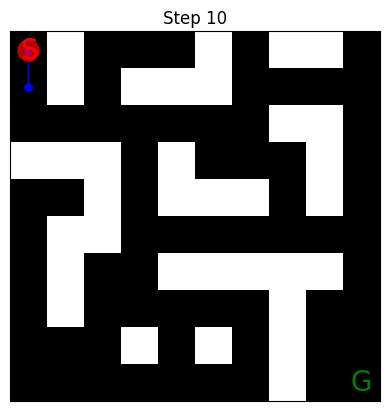

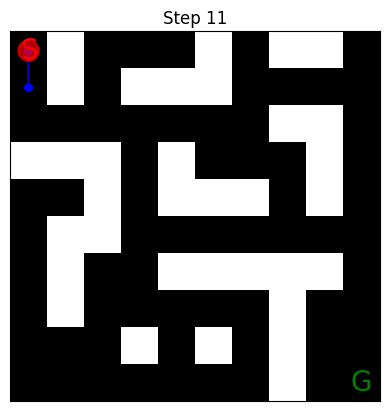

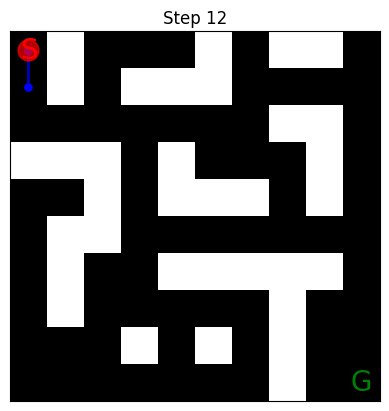

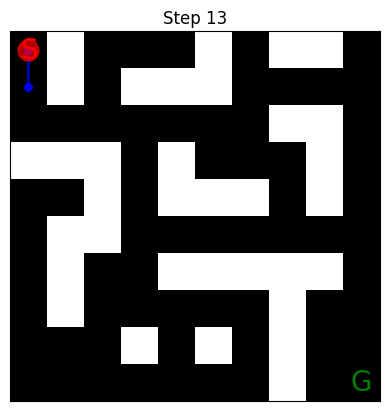

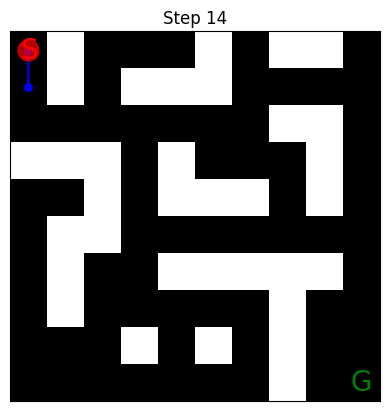

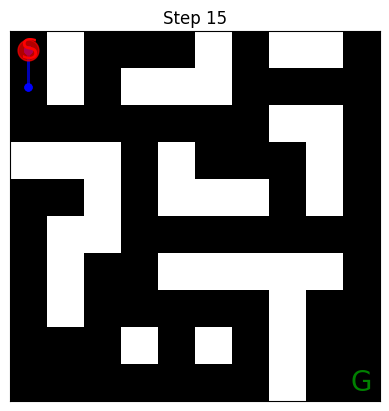

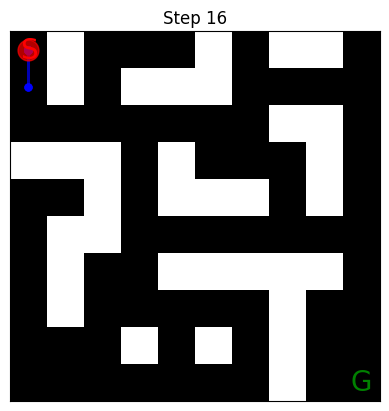

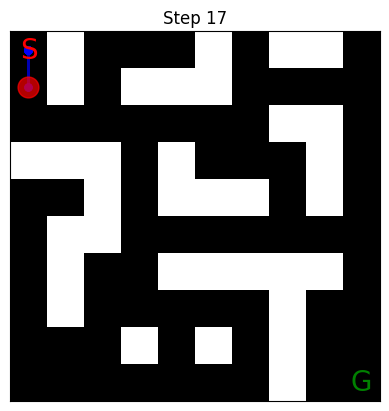

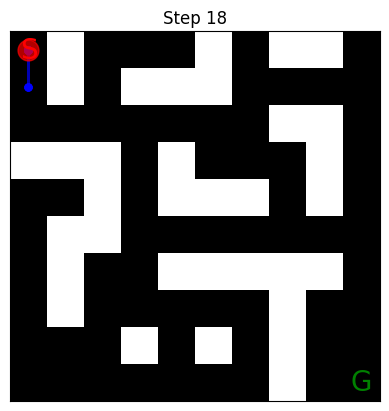

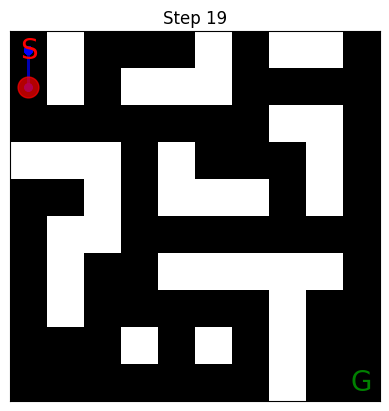

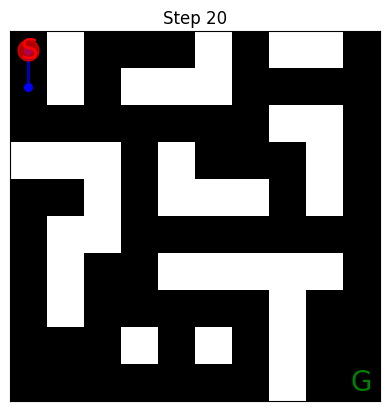

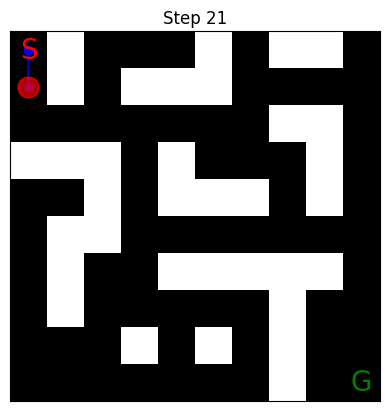

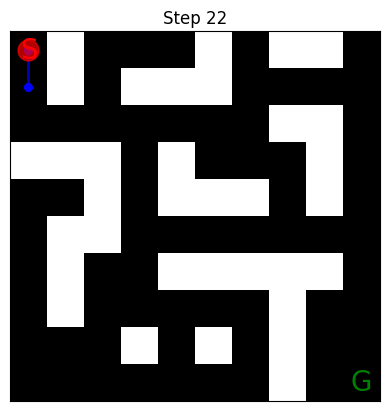

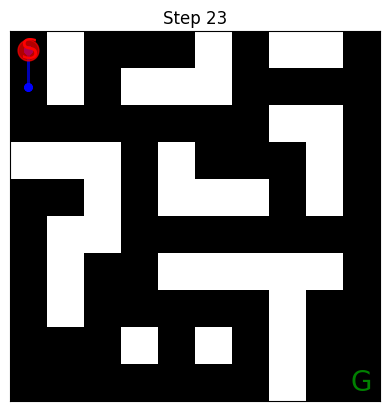

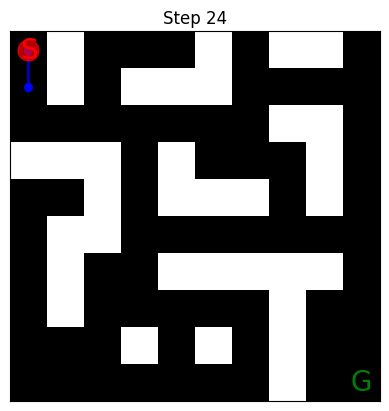

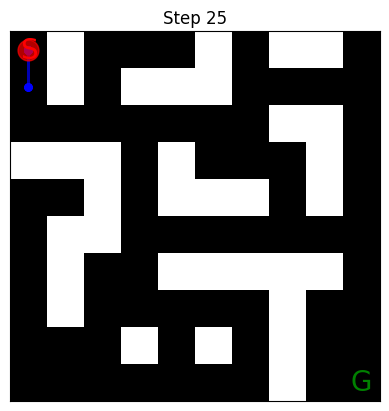

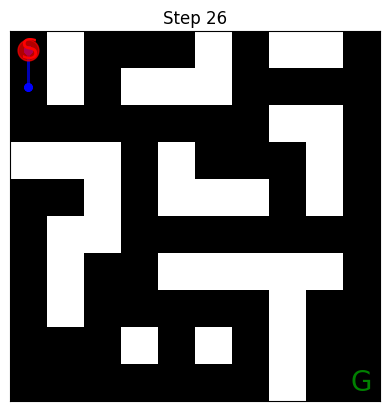

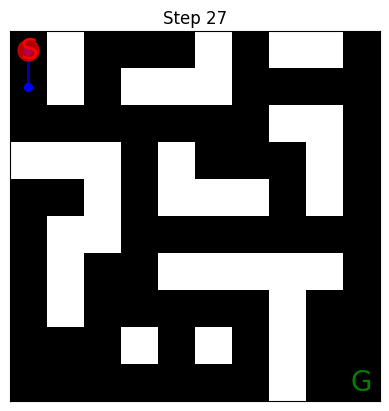

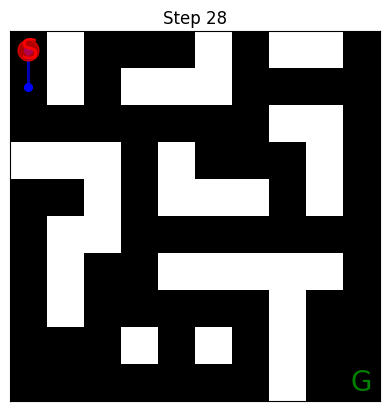

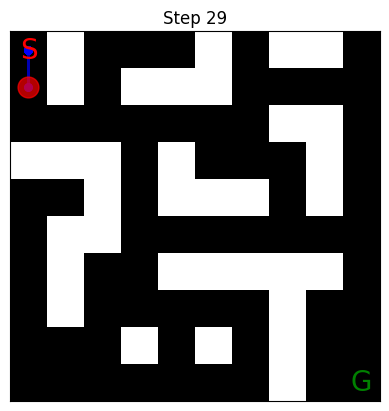

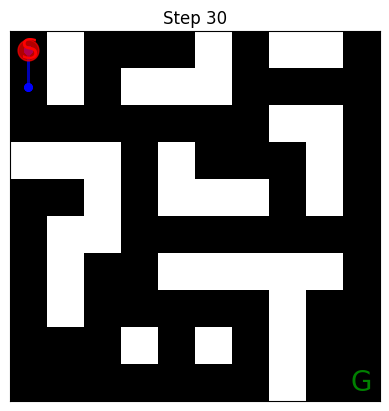

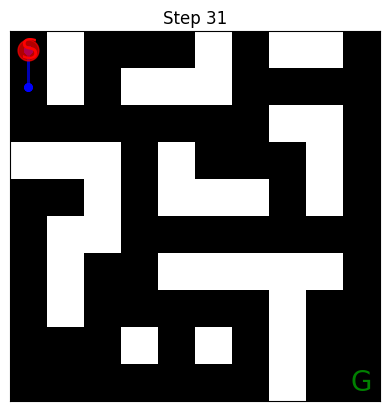

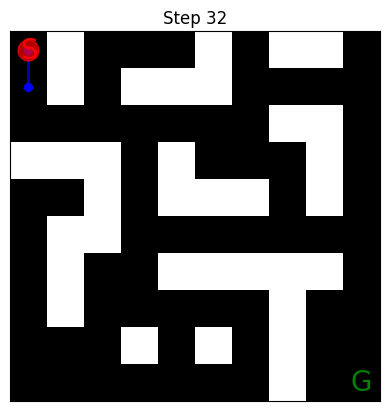

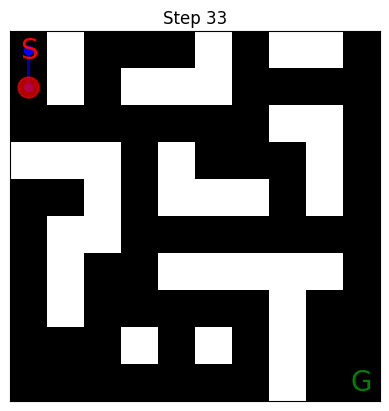

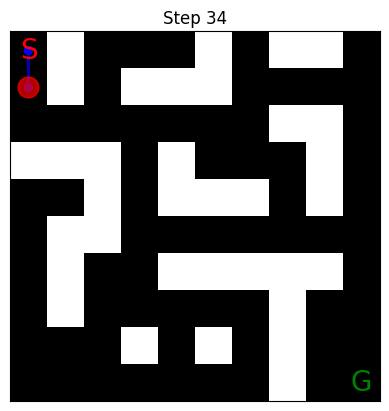

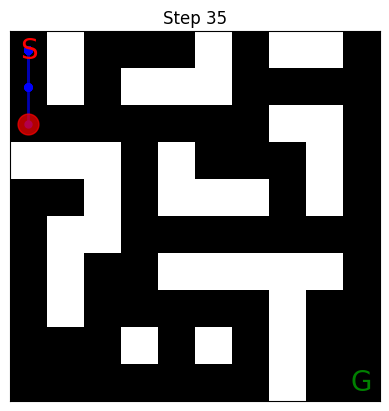

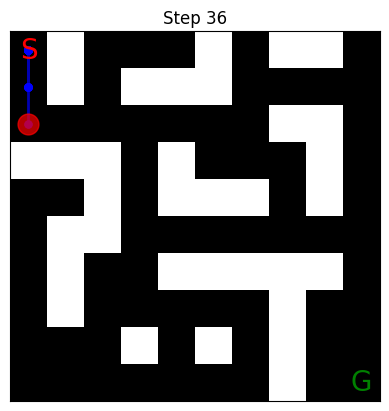

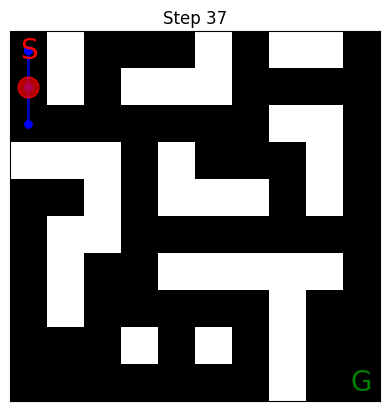

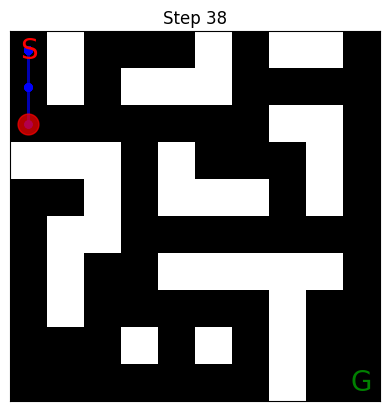

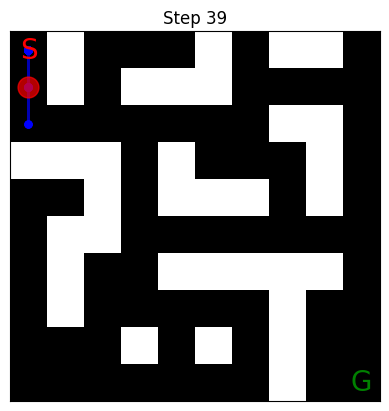

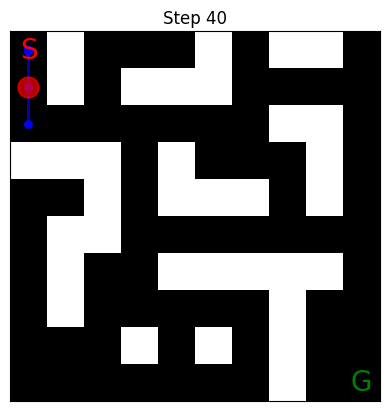

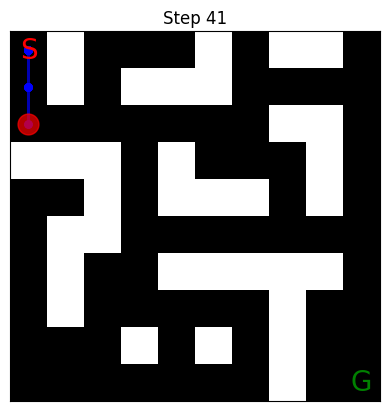

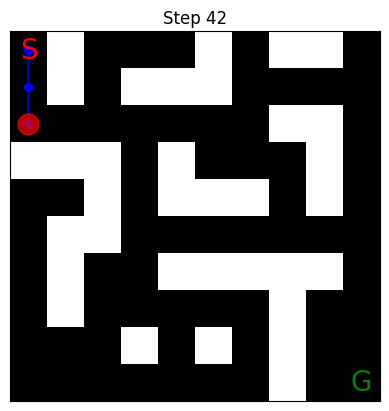

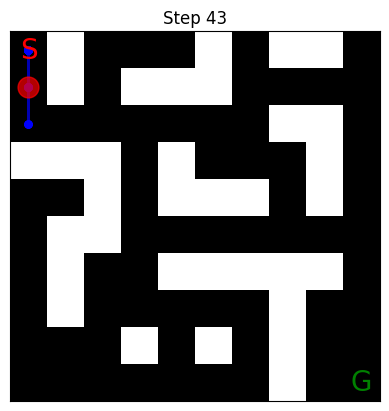

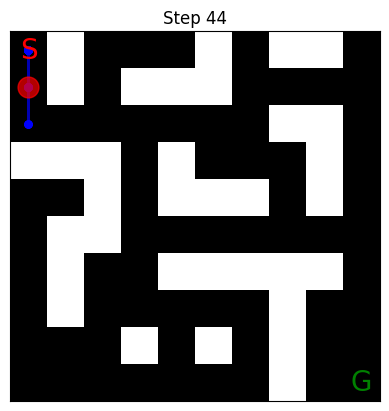

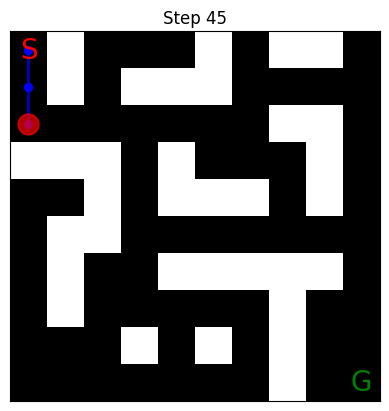

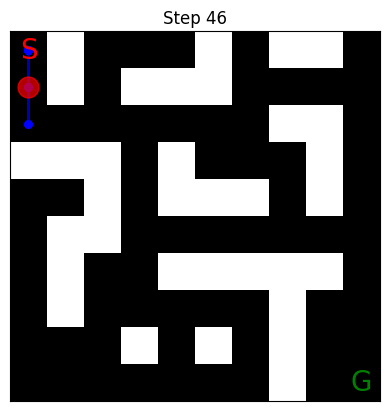

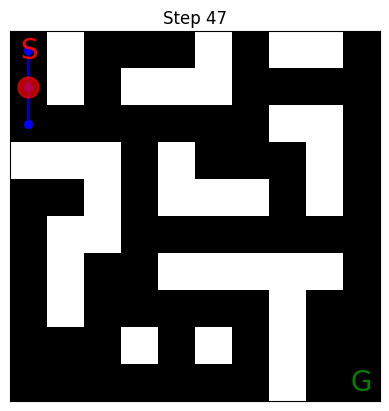

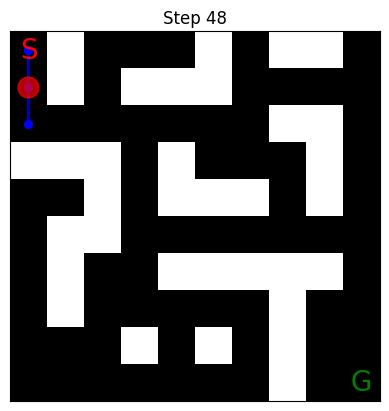

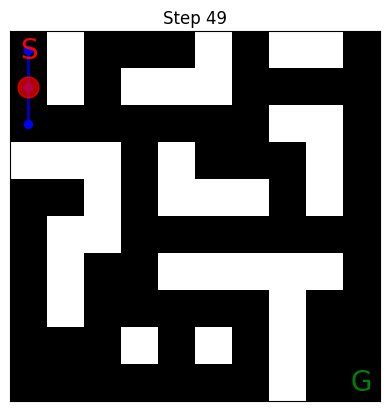

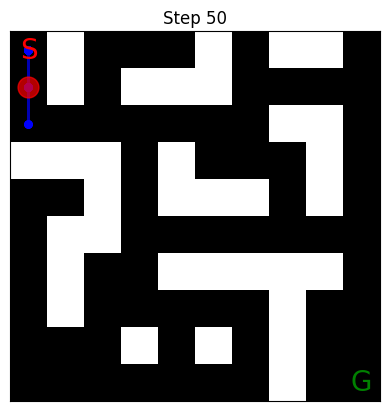

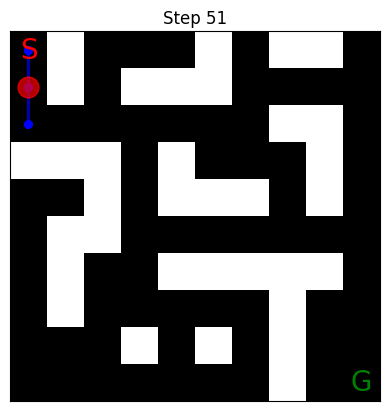

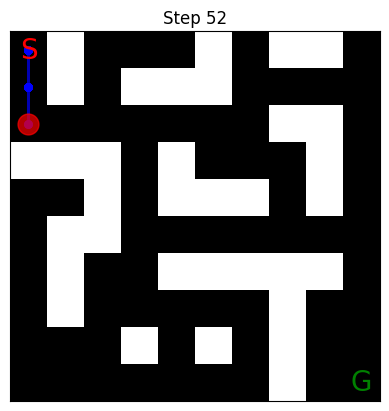

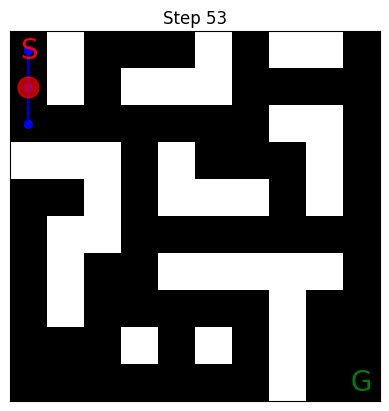

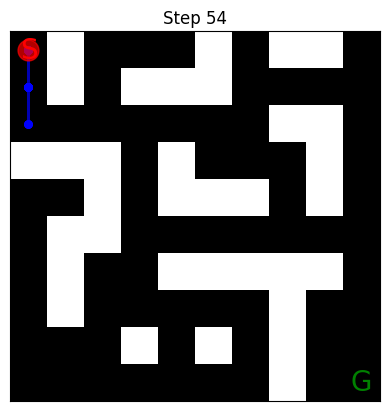

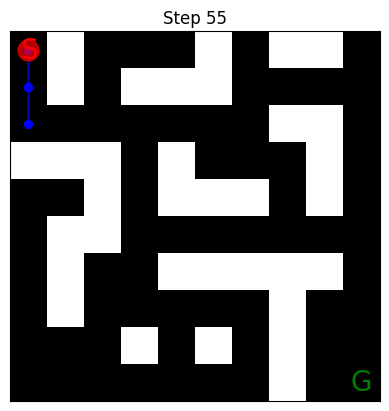

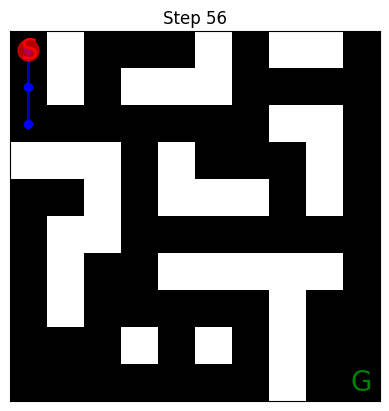

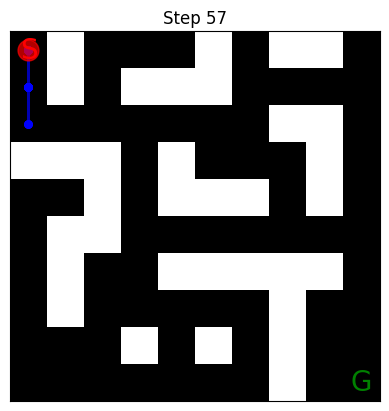

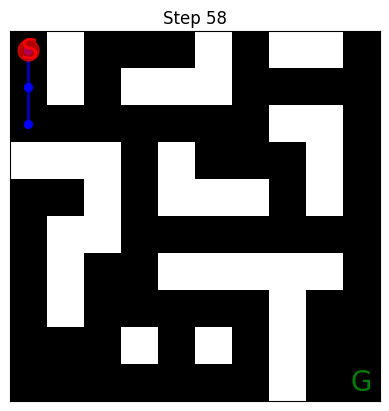

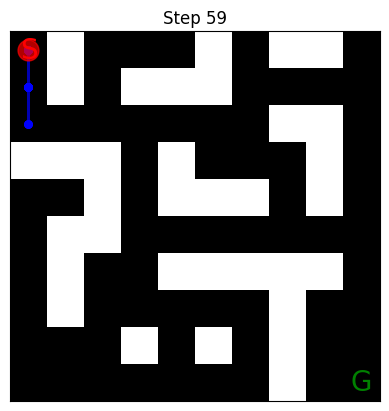

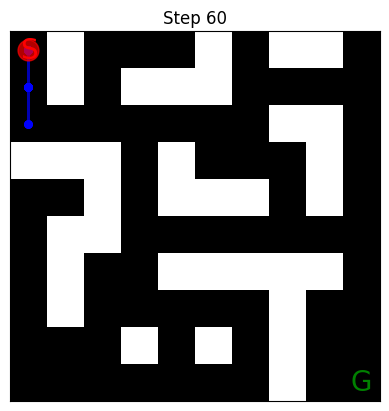

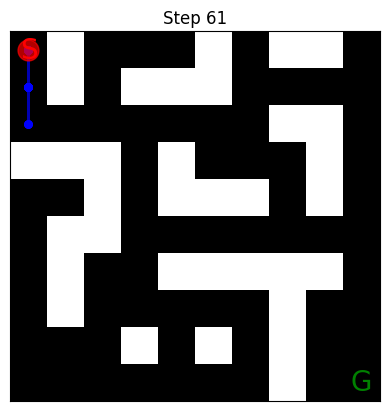

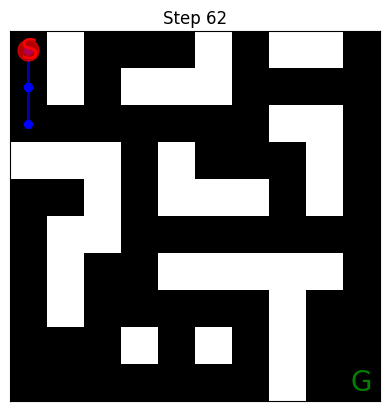

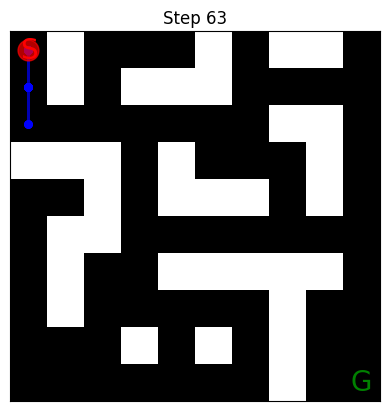

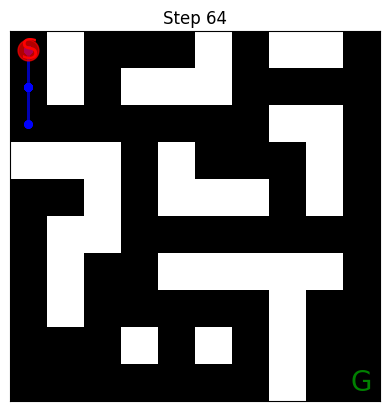

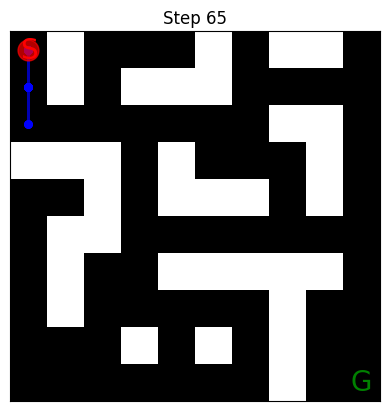

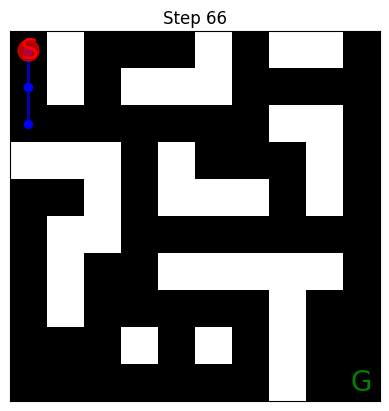

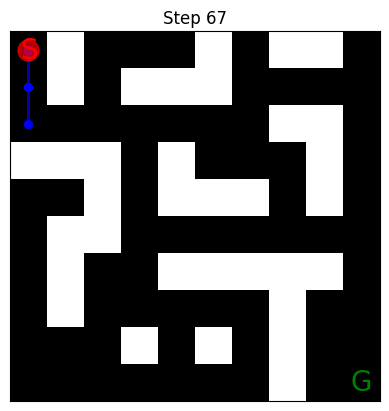

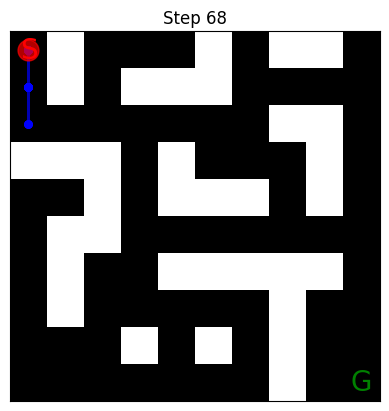

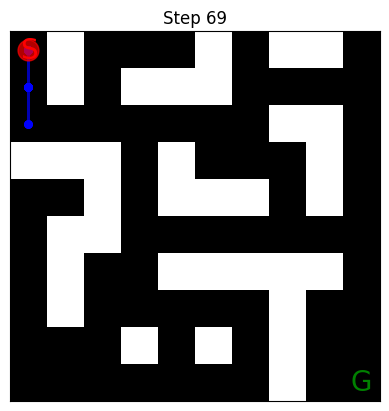

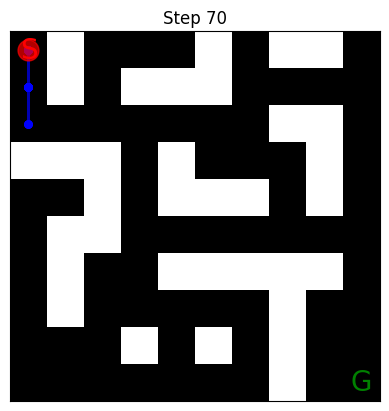

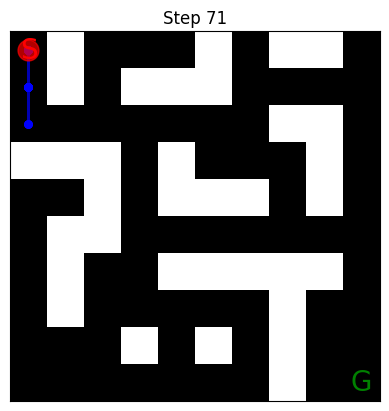

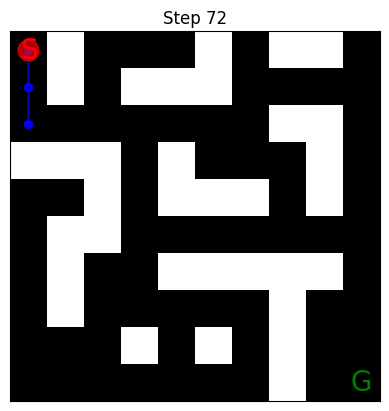

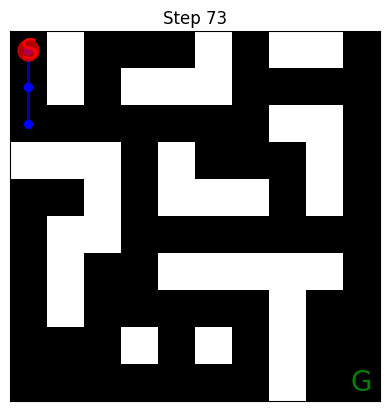

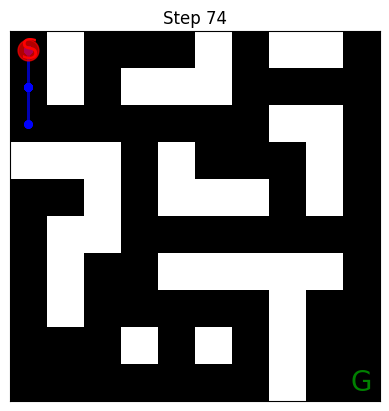

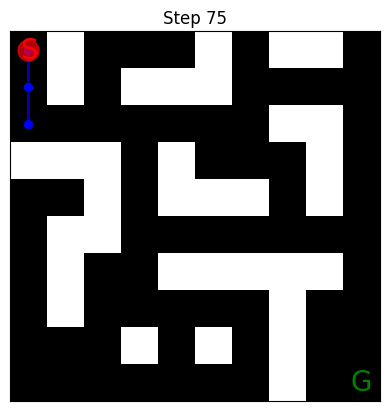

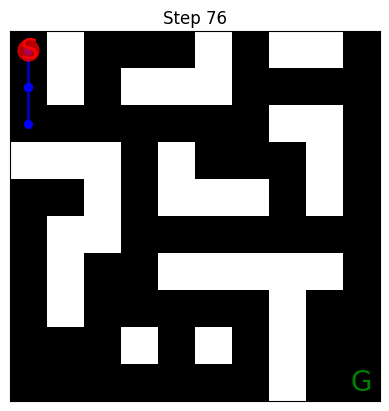

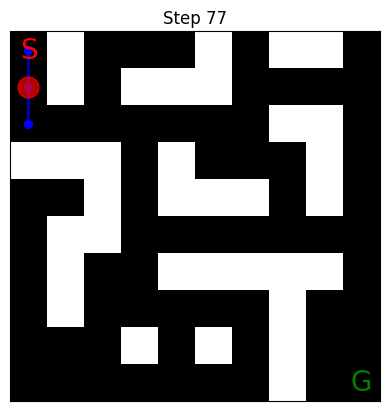

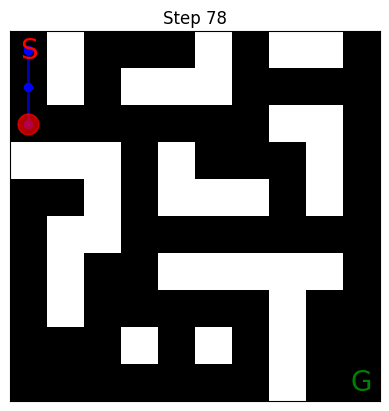

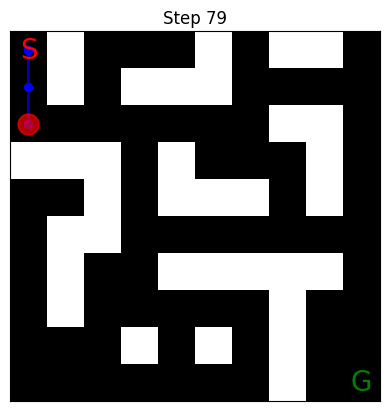

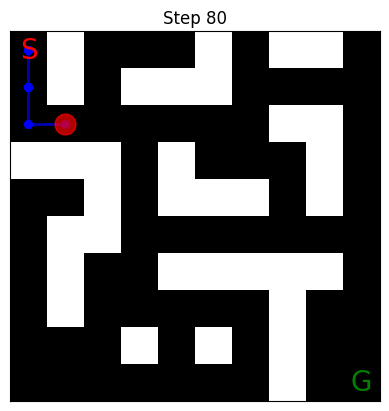

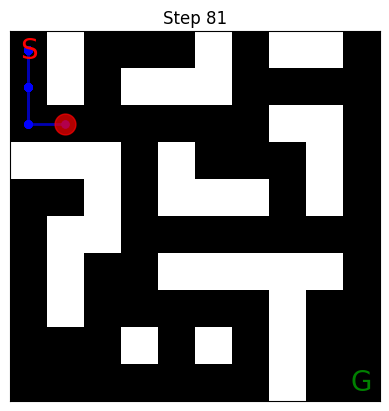

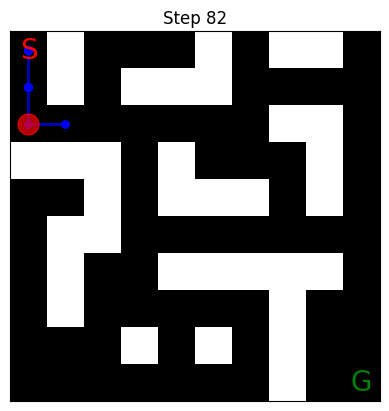

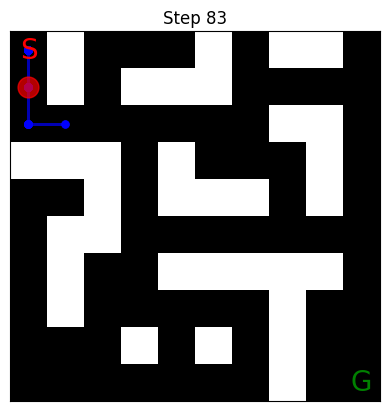

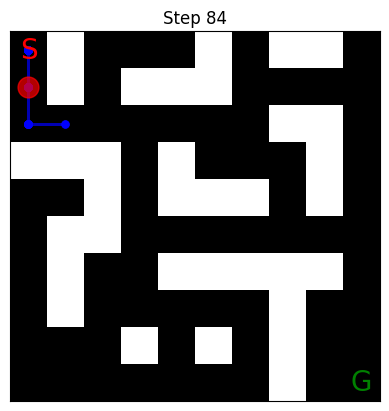

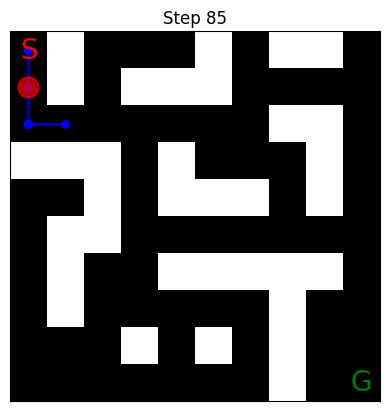

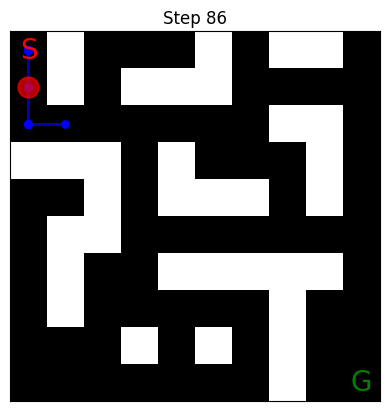

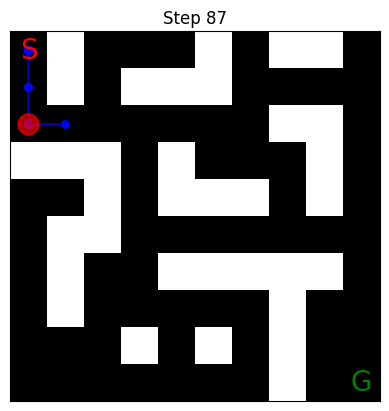

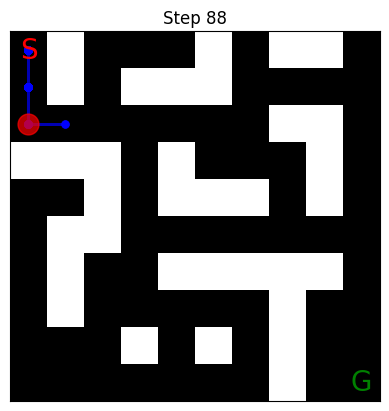

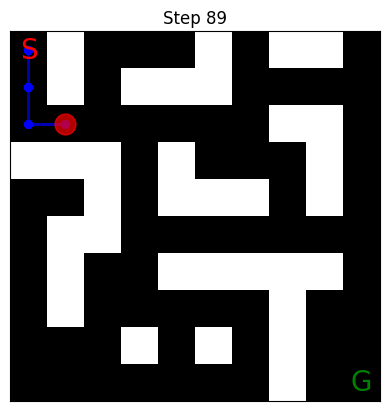

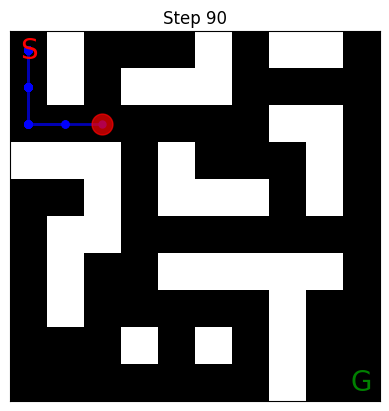

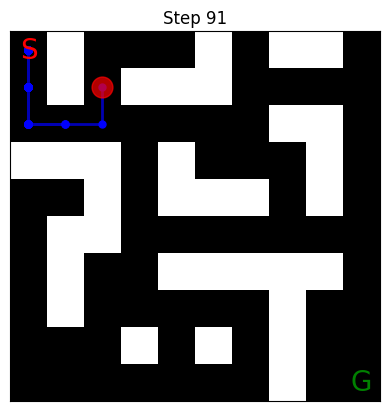

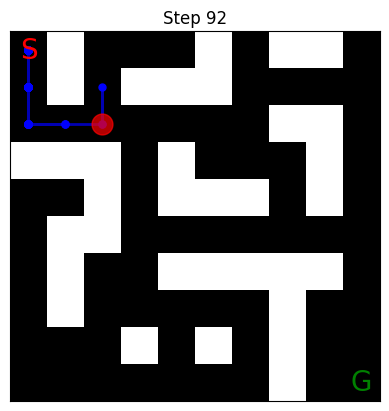

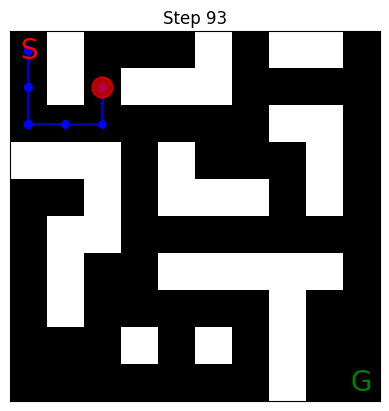

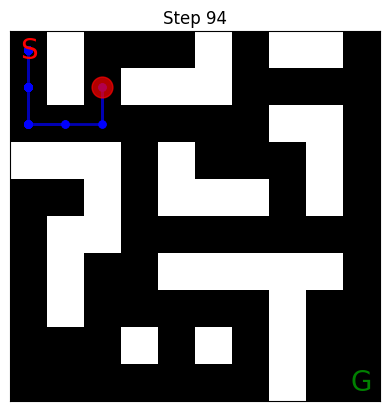

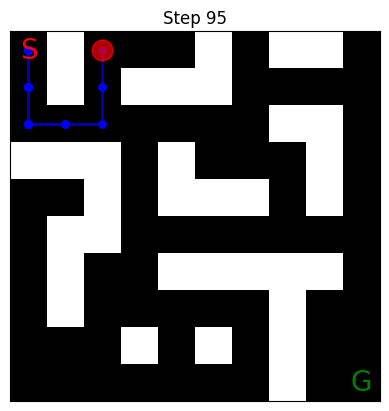

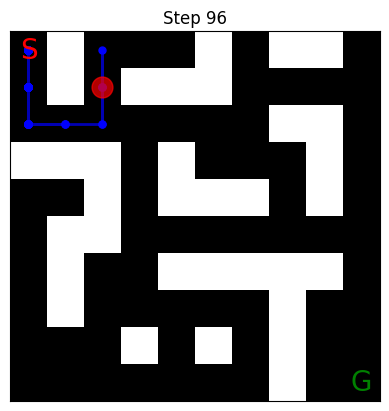

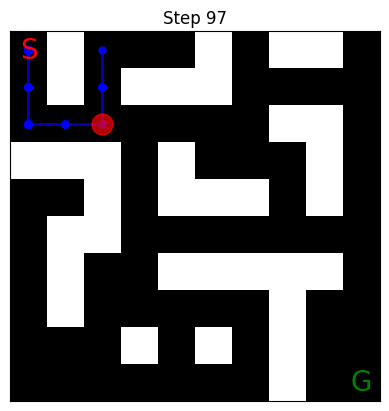

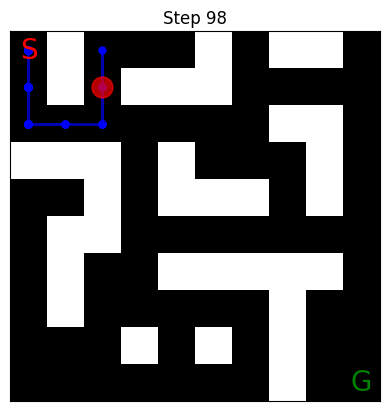

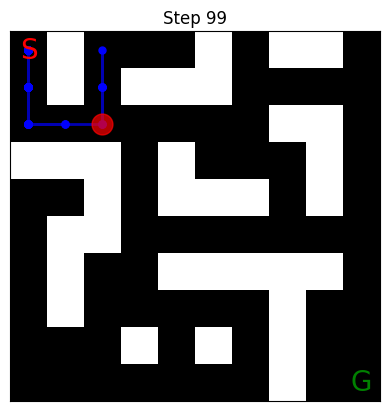

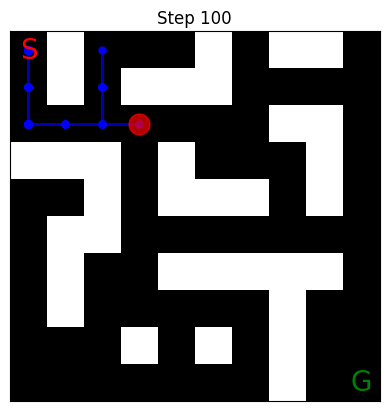

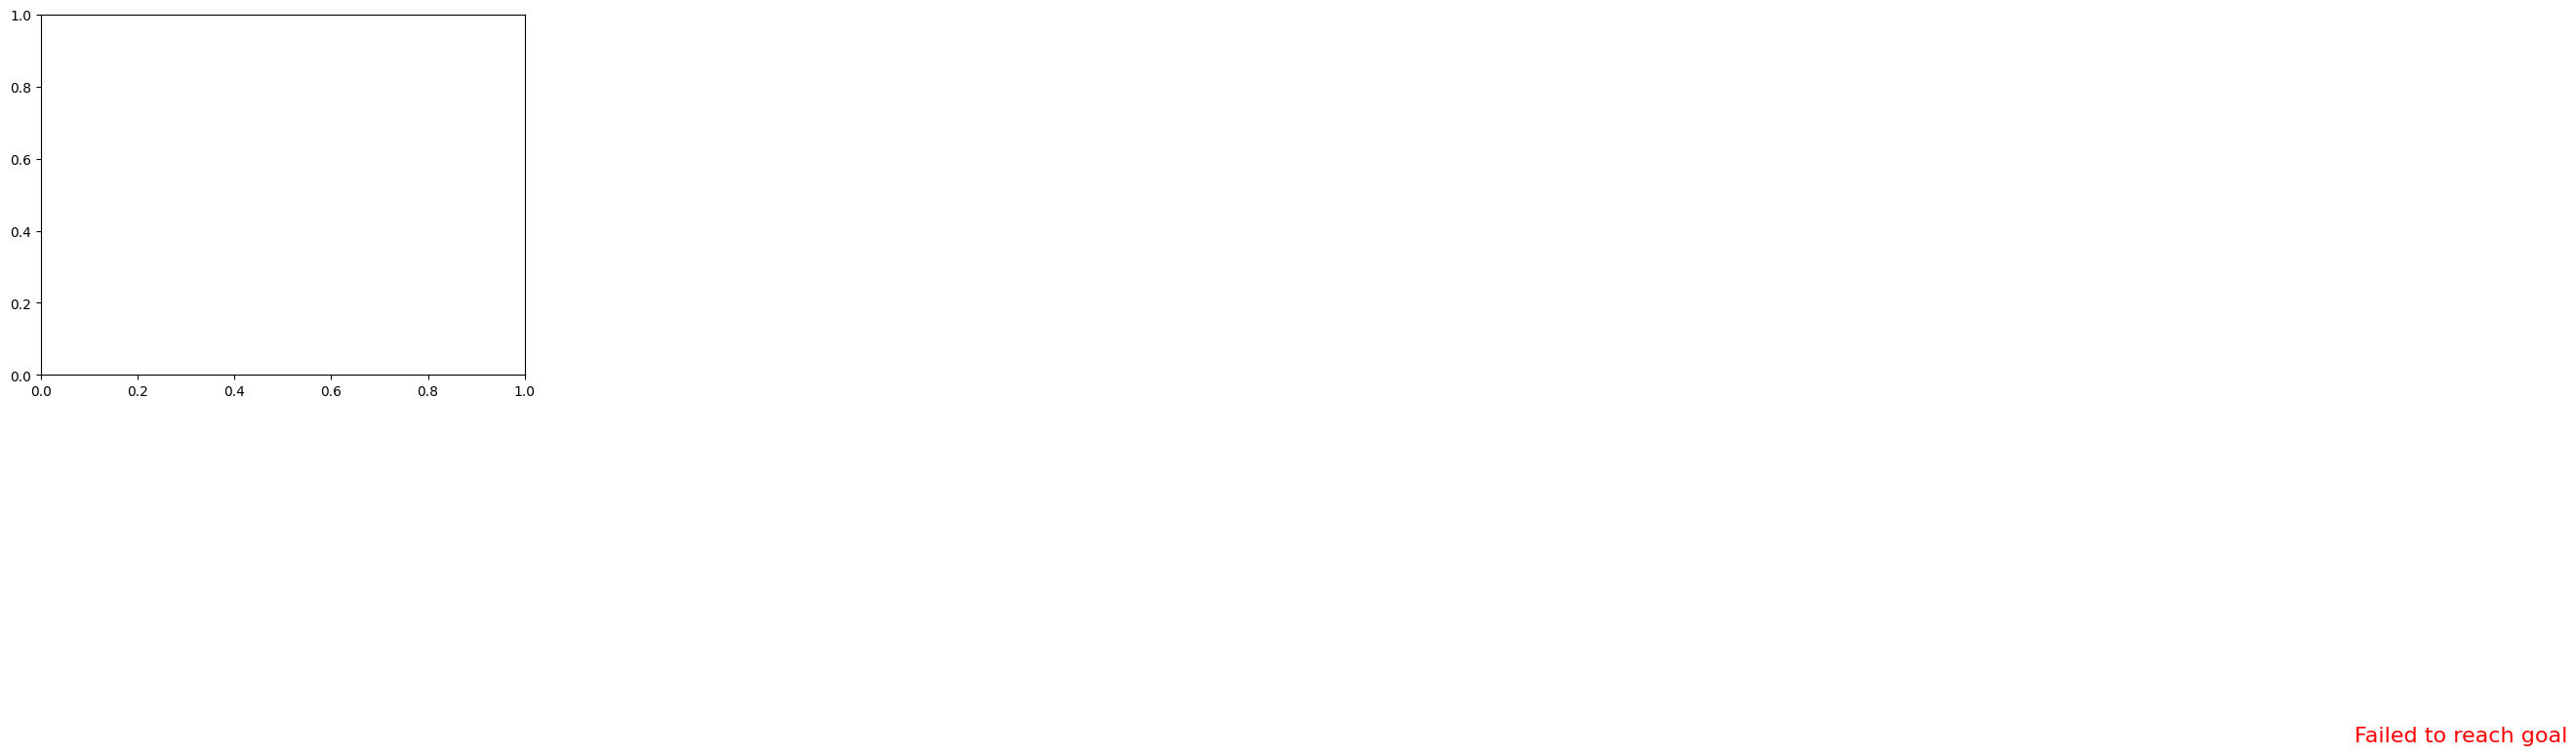


Training Agent...
Episode 100/1000, Avg Reward: -297.80, Avg Steps: 91.40, Best Steps: 25
Episode 200/1000, Avg Reward: -192.67, Avg Steps: 77.42, Best Steps: 25
Episode 300/1000, Avg Reward: -104.28, Avg Steps: 59.45, Best Steps: 22
Episode 400/1000, Avg Reward: -102.39, Avg Steps: 61.77, Best Steps: 22
Episode 500/1000, Avg Reward: -104.37, Avg Steps: 62.62, Best Steps: 22
Episode 600/1000, Avg Reward: -63.84, Avg Steps: 52.16, Best Steps: 20
Episode 700/1000, Avg Reward: -4.57, Avg Steps: 37.41, Best Steps: 18
Episode 800/1000, Avg Reward: -10.12, Avg Steps: 39.48, Best Steps: 18
Episode 900/1000, Avg Reward: 17.93, Avg Steps: 31.03, Best Steps: 18
Episode 1000/1000, Avg Reward: 31.42, Avg Steps: 25.70, Best Steps: 18


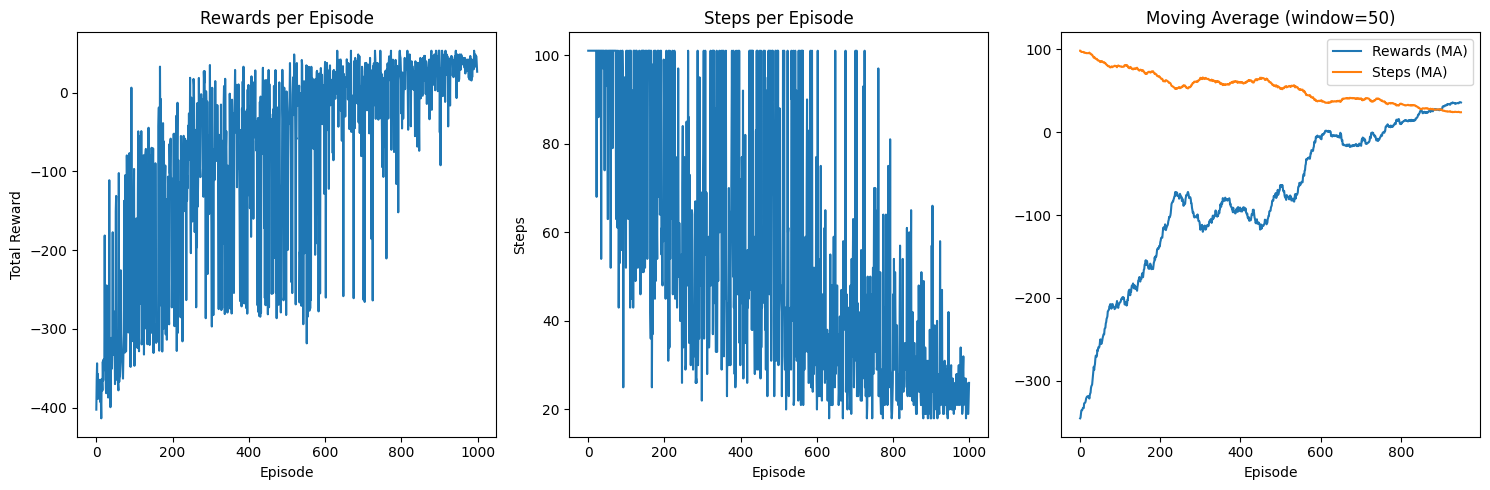


Testing Trained Agent:


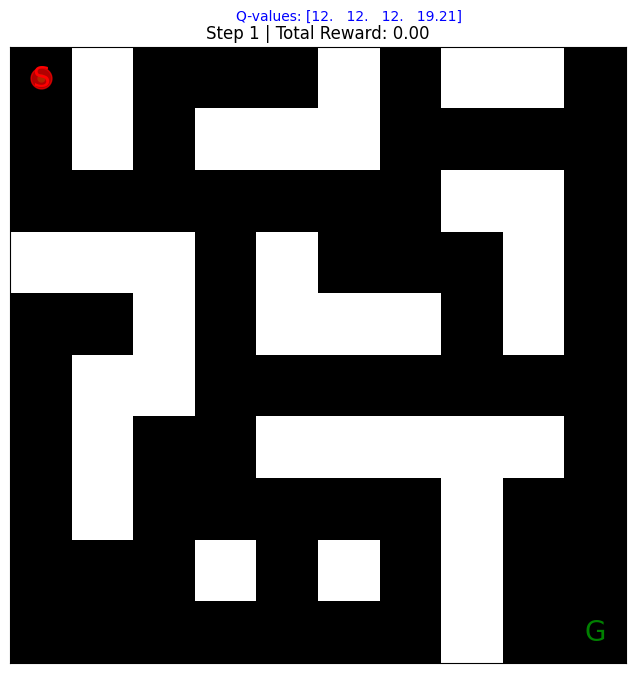

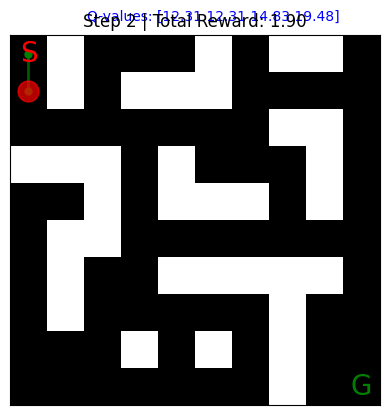

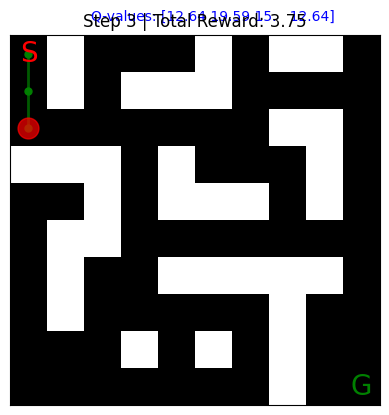

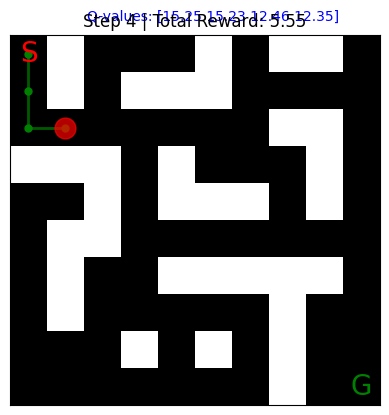

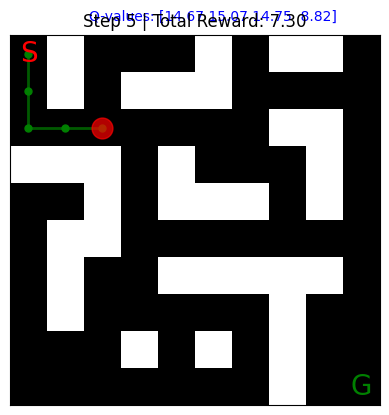

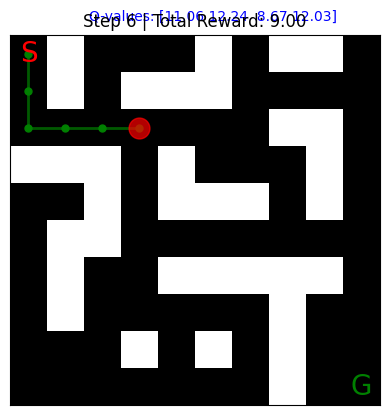

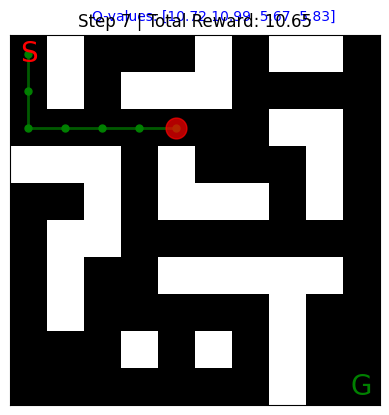

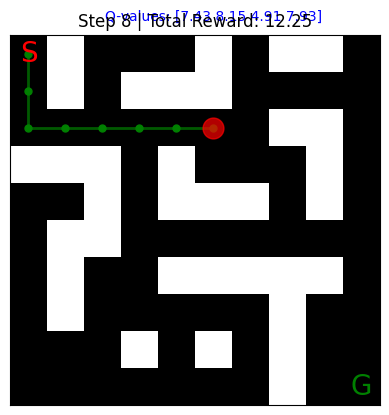

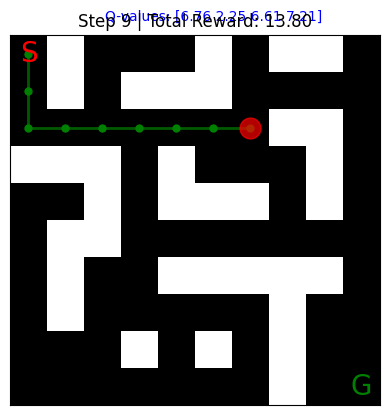

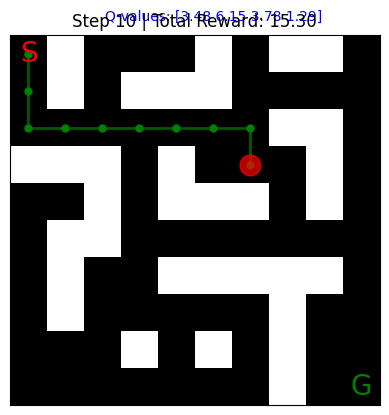

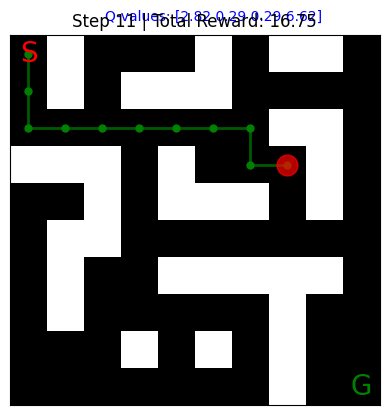

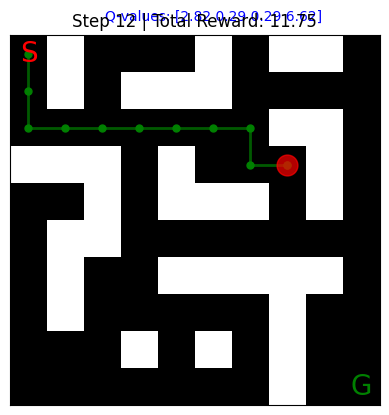

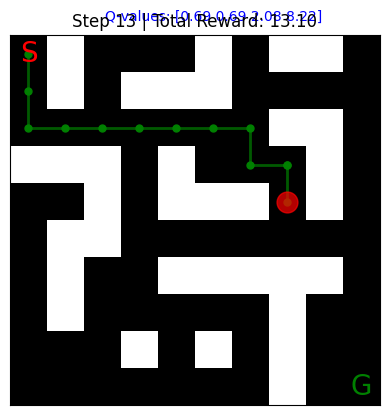

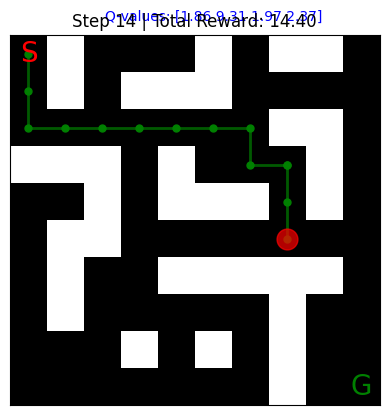

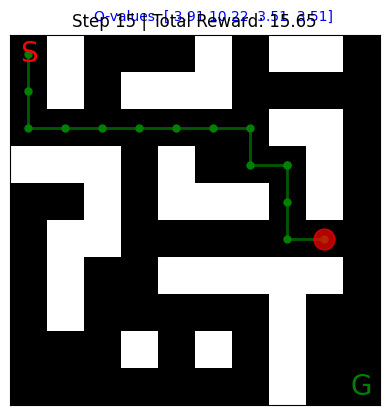

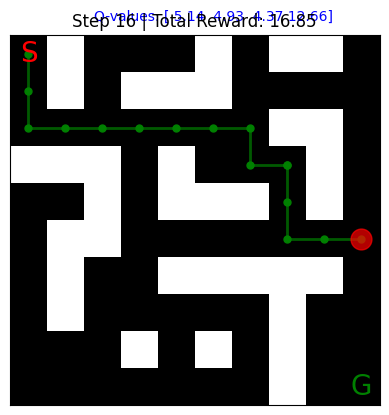

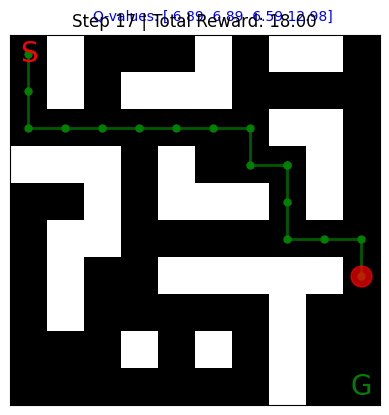

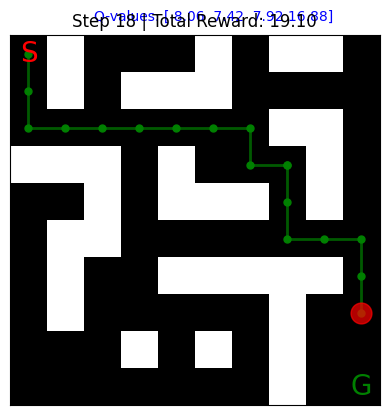

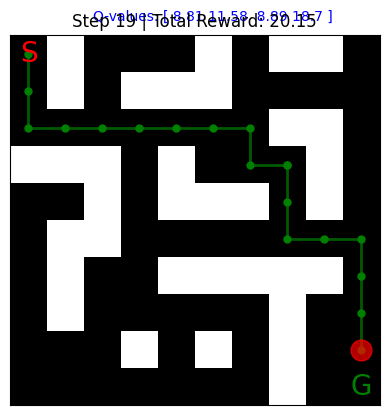

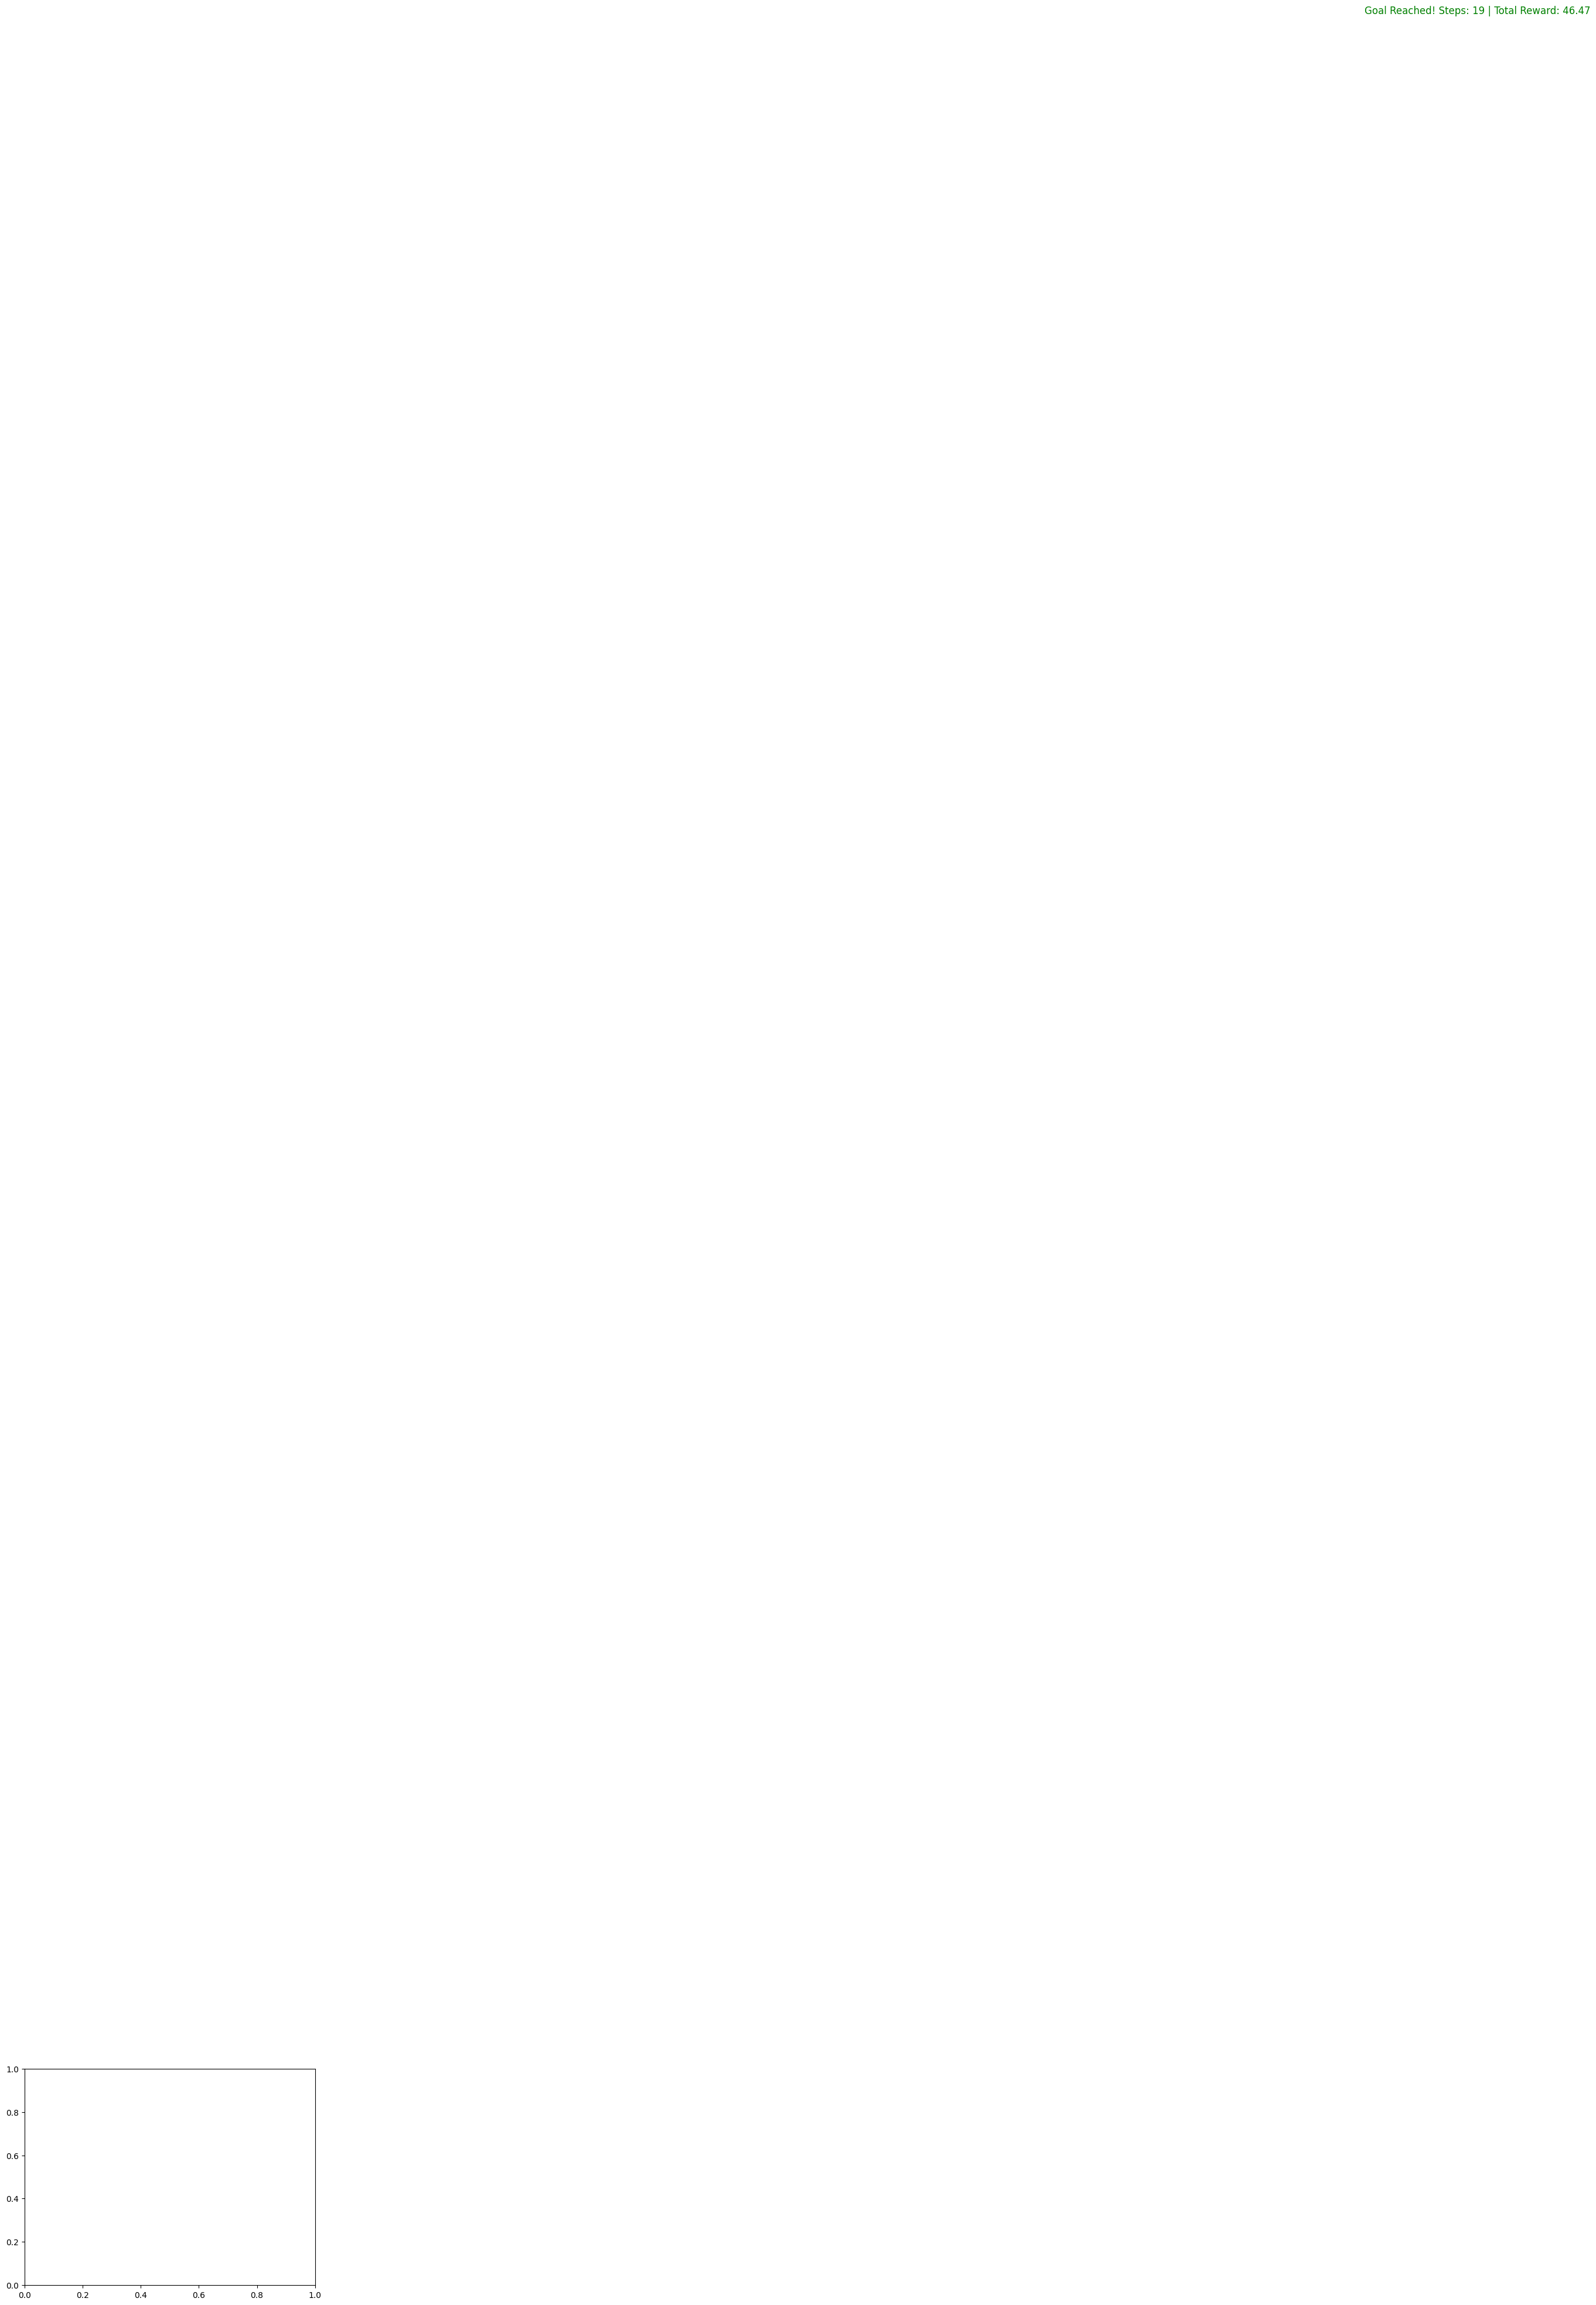


Performance Comparison:
Untrained Agent Steps: 100
Trained Agent Steps: 19
Improvement: 81.00%
Final Reward: 46.47


In [6]:
# Compare performance (this will show untrained, then train, then show trained)
untrained_path, trained_path = compare_agent_performance(maze, agent)